# Anticipez les besoins en consommation électrique de bâtiments

**Problématique de la ville de Seattle**  
Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.

**Votre mission**  
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

- Réaliser une courte analyse exploratoire.
- Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

L’objectif est de se passer des relevés de consommation annuels (attention à la fuite de données), mais rien n'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

Faire bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mettre en place une évaluation rigoureuse des performances de la régression, et optimiser les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.

**Livrables attendus**  
- Un notebook de l'analyse exploratoire mis au propre et annoté.
- Le code (ou un notebook) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.
- Un support de présentation pour la soutenance.

**Compétences évaluées**  
- Mettre en place le modèle d'apprentissage supervisé adapté au problème métier
- Évaluer les performances d’un modèle d'apprentissage supervisé
- Adapter les hyperparamètres d'un algorithme d'apprentissage supervisé afin de l'améliorer
- Transformer les variables pertinentes d'un modèle d'apprentissage supervisé

__Techniques__
- ACP: réduction de dimension
- clustering hiérarchique
- knn


# Sommaire

__[I. Chargement et nettoyage des données](#I.-Chargement-et-nettoyage-des-données)__\
[I.1 Descriptions des indicateurs](#I.1-Descriptions-des-indicateurs)\
[I.2 Nettoyage](#I.2-Nettoyage)

__[II. Analyse exploratoire](#II.-Analyse-exploratoire)__\
[II.1 Variables qualitatives et variables quantitatives](#II.1-Variables-qualitatives-et-variables-quantitatives)\
[II.2 Variables quantitatives](#II.2-Variables-quantitatives)\
[II.2.1 Distribution des variables quantitatives](#II.2.1-Distribution-des-variables-quantitatives)\
[II.2.2 outliers](#II.2.2-outliers)\
[II.2.3 Transformation des variables cibles](#II.2.3-Transformation-des-variables-cibles)\
[II.2.4 Suppression de PropertyGFATotal](#II.2.4-Suppression-de-PropertyGFATotal)\
[II.2.5 Corrélations des variables quantitatives](#II.2.5-Corrélations-des-variables-quantitatives)\
[II.3 Variables catégorielles](#II.3-Variables-catégorielles)\
[II.3.1 Tour d'horizon des variables catégorielles](#II.3.1-Tour-d'horizon-des-variables-catégorielles)\
[II.3.2 Etude des corrélations](#II.3.2-Etude-des-corrélations)

__[III Modèles Linéaires](#III-Modèles-Linéaires)__\
[III.1 Régression linéaire simple avec toutes les variables](#III.1-Régression-linéaire-simple-avec-toutes-les-variables)\
[III.3 RidgeCV](#III.3-RidgeCV)\
[III.4 LassoCV](#III.4-LassoCV)\
[III.5 ElasticNet](#III.5-ElasticNet)\

__[IV kNN](#IV-kNN)__

__[V SVM](#V-SVM)__

__[VI Modèles non-linéaires](#VI-Modèles-non-linéaires)__\
[VI.1 SVM à noyau](#VI.1-SVM-à-noyau)\
[VI.2 Régression ridge à noyau](#VI.2-Régression-ridge-à-noyau)

__[VII Méthodes ensemblistes](#VII-Méthodes-ensemblistes)__\
[VII.1 Forêts aléatoires](#VII.1-Forêts-aléatoires)\
__[A suivre: Latitude, Longitude](#A-suivre:-Latitude,-Longitude)__

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

# I. Chargement et nettoyage des données

## I.1 Descriptions des indicateurs

In [98]:
data2015 = pd.read_csv("./data/2015-building-energy-benchmarking.csv")
data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,...,GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,...,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,...,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,...,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,...,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,...,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [99]:
indicators = pd.Series(data2015.columns, name="indicators")
indicators

0                                         OSEBuildingID
1                                              DataYear
2                                          BuildingType
3                                   PrimaryPropertyType
4                                          PropertyName
5                         TaxParcelIdentificationNumber
6                                              Location
7                                   CouncilDistrictCode
8                                          Neighborhood
9                                             YearBuilt
10                                    NumberofBuildings
11                                       NumberofFloors
12                                     PropertyGFATotal
13                                   PropertyGFAParking
14                               PropertyGFABuilding(s)
15                            ListOfAllPropertyUseTypes
16                               LargestPropertyUseType
17                            LargestPropertyUse

Maintenant 2016-building-energy-benchmarking

In [100]:
data2016 = pd.read_csv("./data/2016-building-energy-benchmarking.csv")
indicators_2016 = pd.Series(data2016.columns, name="indicators_2016")
indicators_2016

0                       OSEBuildingID
1                            DataYear
2                        BuildingType
3                 PrimaryPropertyType
4                        PropertyName
5                             Address
6                                City
7                               State
8                             ZipCode
9       TaxParcelIdentificationNumber
10                CouncilDistrictCode
11                       Neighborhood
12                           Latitude
13                          Longitude
14                          YearBuilt
15                  NumberofBuildings
16                     NumberofFloors
17                   PropertyGFATotal
18                 PropertyGFAParking
19             PropertyGFABuilding(s)
20          ListOfAllPropertyUseTypes
21             LargestPropertyUseType
22          LargestPropertyUseTypeGFA
23       SecondLargestPropertyUseType
24    SecondLargestPropertyUseTypeGFA
25        ThirdLargestPropertyUseType
26     Third

In [101]:
set(indicators_2016.to_numpy()).difference(indicators.to_numpy())

{'Address',
 'City',
 'Comments',
 'GHGEmissionsIntensity',
 'Latitude',
 'Longitude',
 'State',
 'TotalGHGEmissions',
 'ZipCode'}

In [102]:
set(indicators.to_numpy()).difference(set(indicators_2016.to_numpy()))

{'2010 Census Tracts',
 'City Council Districts',
 'Comment',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Location',
 'OtherFuelUse(kBtu)',
 'SPD Beats',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'Zip Codes'}

#### Indicateurs 2015-building-energy-benchmarking

name | description 
--- | --- |
OSEBuildingID|A unique identifier assigned to each property covered by the Seattle Benchmarking Ordinance for tracking and identification purposes.
"BuildingType"|"City of Seattle building type classification."
PrimaryPropertyType|The primary use of a property (e.g. office, retail store). Primary use is defined as a function that accounts for more than 50% of a property. This is the Property Type - EPA Calculated field from Portfolio Manager.
PropertyName|Official or common property name.
TaxParcelIdentificationNumber|Property King County PIN
CouncilDistrictCode|Property City of Seattle council district.
YearBuilt|Year in which a property was constructed or underwent a complete renovation.
PropertyGFATotal|Total building and parking gross floor area.
PropertyGFAParking|Total space in square feet of all types of parking (Fully Enclosed, Partially Enclosed, and Open).
PropertyGFABuilding(s)|Total floor space in square feet between the outside surfaces of a building’s enclosing walls. This includes all areas inside the building(s), such as tenant space, common areas, stairwells, basements, storage, etc.
ENERGYSTARScore|An EPA calculated 1-100 rating that assesses a property’s overall energy performance, based on national data to control for differences among climate, building uses, and operations. A score of 50 represents the national median.
SiteEUI(kBtu/sf)|Site Energy Use Intensity (EUI) is a property's Site Energy Use divided by its gross floor area. Site Energy Use is the annual amount of all the energy consumed by the property on-site, as reported on utility bills. Site EUI is measured in thousands of British thermal units (kBtu) per square foot.
SiteEUIWN(kBtu/sf)|Weather Normalized (WN) Site Energy Use Intensity (EUI) is a property's WN Site Energy divided by its gross floor area (in square feet). WN Site Energy is the Site Energy Use the property would have consumed during 30-year average weather conditions. WN Site EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SourceEUI(kBtu/sf)|Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.
SourceEUIWN(kBtu/sf)|Weather Normalized (WN) Source Energy Use Intensity (EUI) is a property's WN Source Energy divided by its gross floor area. WN Source Energy is the Source Energy Use the property would have consumed during 30-year average weather conditions. WN Source EUI is measured in measured in thousands of British thermal units (kBtu) per square foot.
SiteEnergyUse(kBtu)|The annual amount of energy consumed by the property from all sources of energy.
SteamUse(kBtu)|The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).
Electricity(kWh)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in kWh.
Electricity(kBtu)|The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).
NaturalGas(therms)|The annual amount of utility-supplied natural gas consumed by the property, measured in therms.
GHGEmissions(MetricTonsCO2e)|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity(kgCO2e/ft2)|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources



#### Indicateurs 2016-building-energy-benchmarking

name | description 
--- | --- |
TotalGHGEmissions|The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.
GHGEmissionsIntensity|Total Greenhouse Gas Emissions divided by property's gross floor area, measured in kilograms of carbon dioxide equivalent per square foot. This calculation uses a GHG emissions factor from Seattle City Light's portfolio of generating resources

Plusieurs indicateurs différents.

In [103]:
data2015.Location.iloc[0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

Il semblerait que les colonnes Latitude Longitude Address City State ZipCode soient contenues dans Location

Dans la table 2015, Zip Codes semble être générées automatiquement - on ne la garde pas dans un premier temps.

In [104]:
data2015.drop(columns="Zip Codes", inplace=True)

On va donc, dans la table 2015: 
- splitter Location en Latitude, Longitude, Address City State ZipCode
- Retirer Zip Codes

Renommer certaines colonnes pour assurer la correspondance avec 2016, de façon à fusionner les tables
- GHGEmissions(MetricTonsCO2e) (2015) et TotalGHGEmissions (2016) sont en fait les mêmes colonnes
- GHGEmissionsIntensity(kgCO2e/ft2) et GHGEmissionsIntensity sont les mêmes colonnes

In [105]:
from ast import literal_eval # module pour évaluer une expression et renvoyer l'objet correspondant

data2015["Location"] = data2015["Location"].apply(literal_eval) # convertit les str en dict
df = pd.json_normalize(data2015["Location"]) # Normalize semi-structured JSON data into a flat table.
df.human_address = df.human_address.apply(literal_eval)
df2 = pd.json_normalize(df.human_address)
df2.head()

,address,city,state,zip
0,405 OLIVE WAY,SEATTLE,WA,98101
1,724 PINE ST,SEATTLE,WA,98101
2,1900 5TH AVE,SEATTLE,WA,98101
3,620 STEWART ST,SEATTLE,WA,98101
4,401 LENORA ST,SEATTLE,WA,98121


In [106]:
loc = data2015.columns.get_loc("Location")
data2015.drop(columns="Location", inplace=True)
d = pd.concat([df.drop(columns="human_address"), df2], axis=1) # nouveau dataframe à partir des colonnes extraites

for c in d.columns[::-1]: # Insertion des colonnes dans le df original, une par une
    data2015.insert(loc, c, d[c])

data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,latitude,longitude,address,city,...,GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


On renomme les colonnes

In [107]:
data2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"TotalGHGEmissions",
                         "GHGEmissionsIntensity(kgCO2e/ft2)":"GHGEmissionsIntensity",
                         "Comment":"Comments",
                         "latitude":"Latitude", 
                         "longitude":"Longitude", 
                         "address":"Address", 
                         "city":"City",
                         "state":"State"}, inplace=True)

In [108]:
data2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Latitude,Longitude,Address,City,...,TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,Comments,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,...,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,47.61310583,-122.33335756,724 PINE ST,SEATTLE,...,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,...,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,...,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,...,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0


In [124]:
raw_data = pd.concat([data2015, data2016], join="outer")

In [125]:
raw_data_cols = pd.Series(raw_data.columns, name="data_cols")
raw_data_cols

0                                         OSEBuildingID
1                                              DataYear
2                                          BuildingType
3                                   PrimaryPropertyType
4                                          PropertyName
5                         TaxParcelIdentificationNumber
6                                              Latitude
7                                             Longitude
8                                               Address
9                                                  City
10                                                State
11                                                  zip
12                                  CouncilDistrictCode
13                                         Neighborhood
14                                            YearBuilt
15                                    NumberofBuildings
16                                       NumberofFloors
17                                     PropertyG

In [111]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6716 entries, 0 to 3375
Data columns (total 52 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  6716 non-null   int64  
 1   DataYear                                                       6716 non-null   int64  
 2   BuildingType                                                   6716 non-null   object 
 3   PrimaryPropertyType                                            6716 non-null   object 
 4   PropertyName                                                   6716 non-null   object 
 5   TaxParcelIdentificationNumber                                  6714 non-null   object 
 6   Latitude                                                       6716 non-null   object 
 7   Longitude                                                   

## I.2 Nettoyage

<AxesSubplot:>

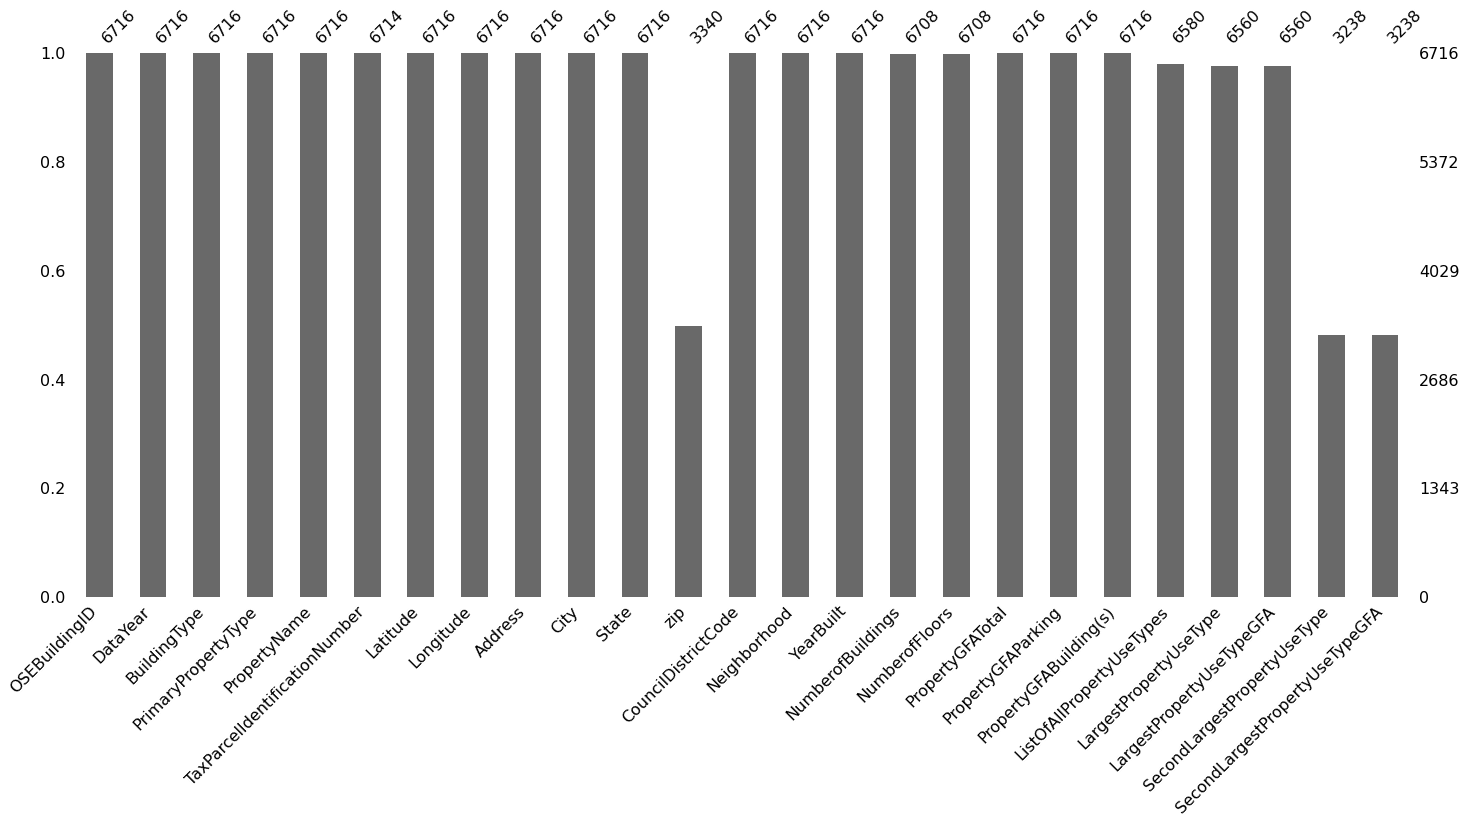

In [112]:
msno.bar(raw_data[raw_data.columns[:25]])

<AxesSubplot:>

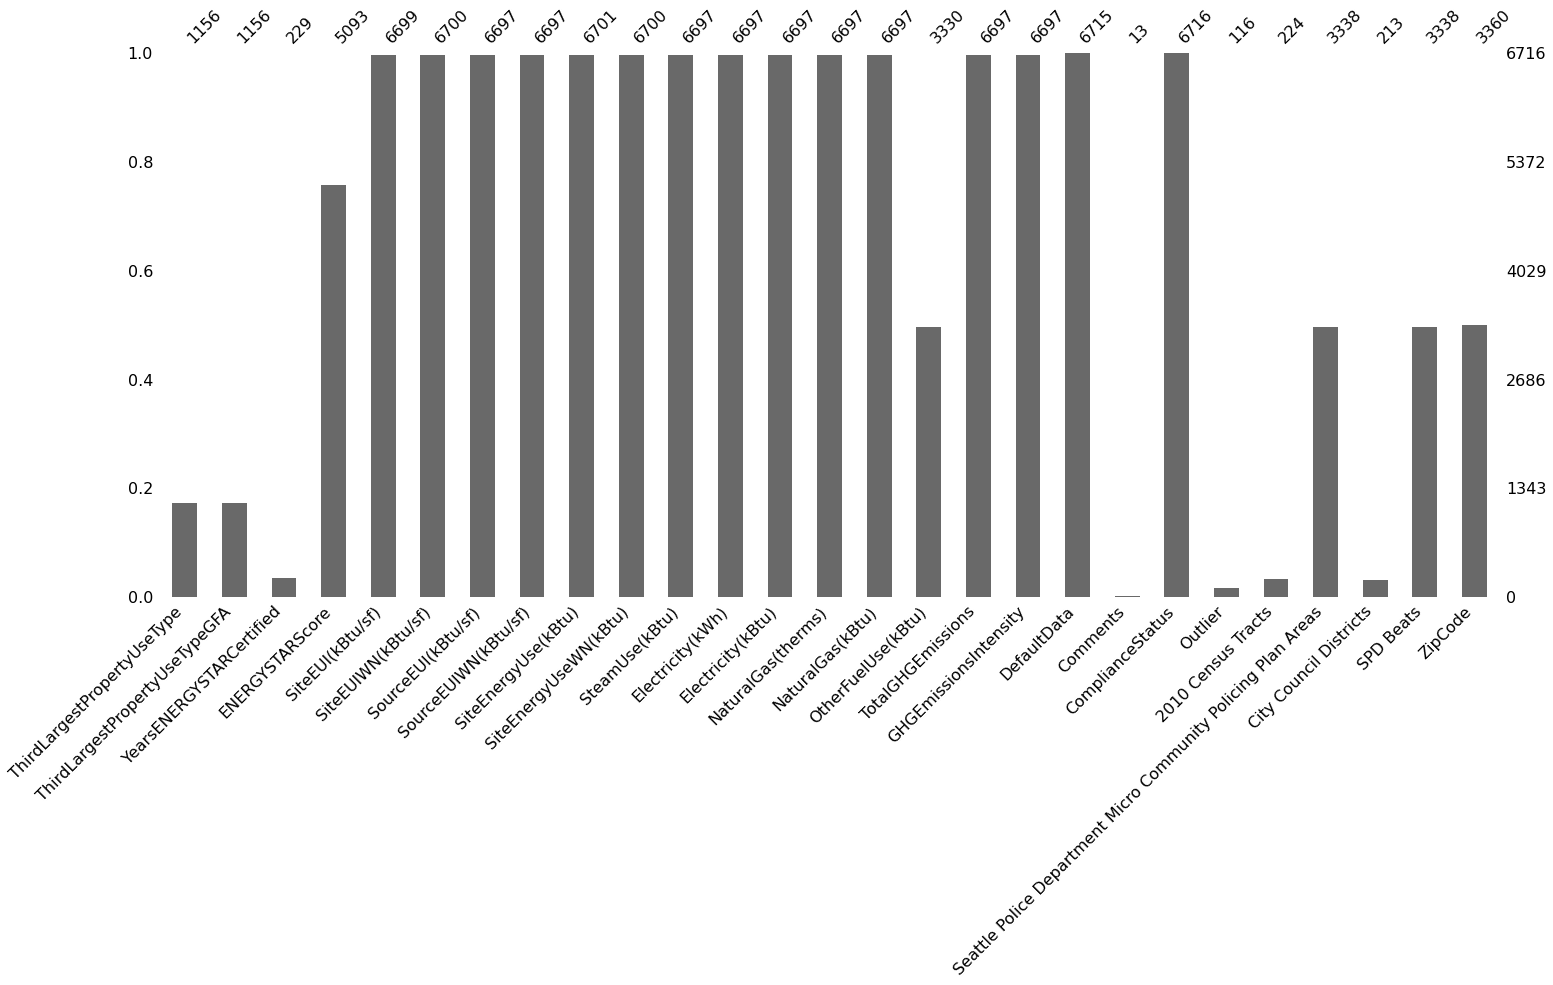

In [113]:
msno.bar(raw_data[raw_data.columns[25:]])

In [1384]:
missing = data.notna().sum()/data.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
Latitude                                                         1.000000
PropertyGFATotal                                                 1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
CouncilDistrictCode                                              1.000000
State                                                            1.000000
City                                                             1.000000
Address                                                          1.000000
Longitude                                                        1.000000
Neighborhood                                                     1.000000
YearBuilt                                                        1.000000
DataYear                                                         1.000000
BuildingType                          

<AxesSubplot:>

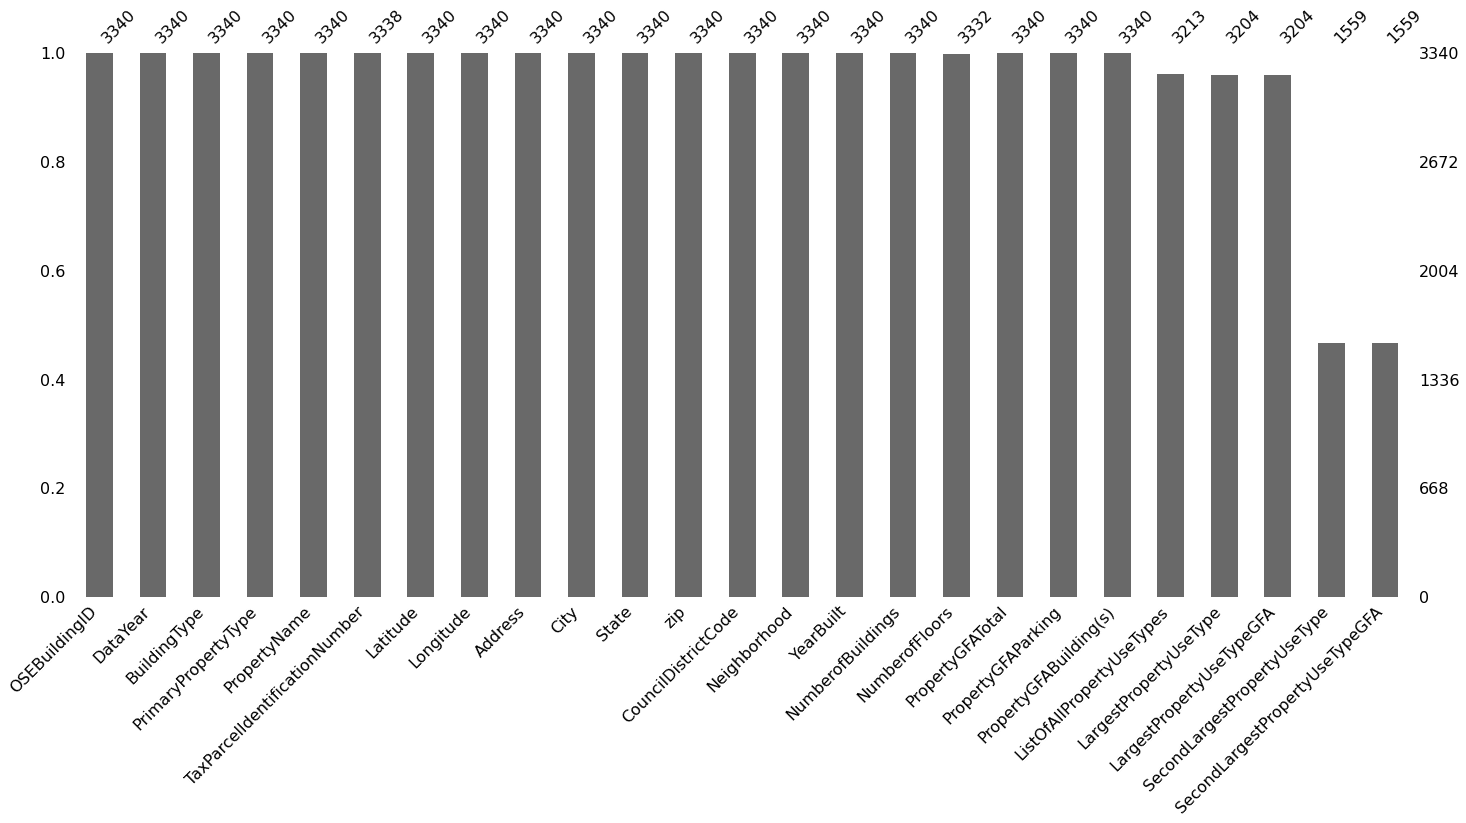

In [114]:
data2015 = raw_data[raw_data.DataYear==2015] 
msno.bar(data2015[data2015.columns[:25]])

<AxesSubplot:>

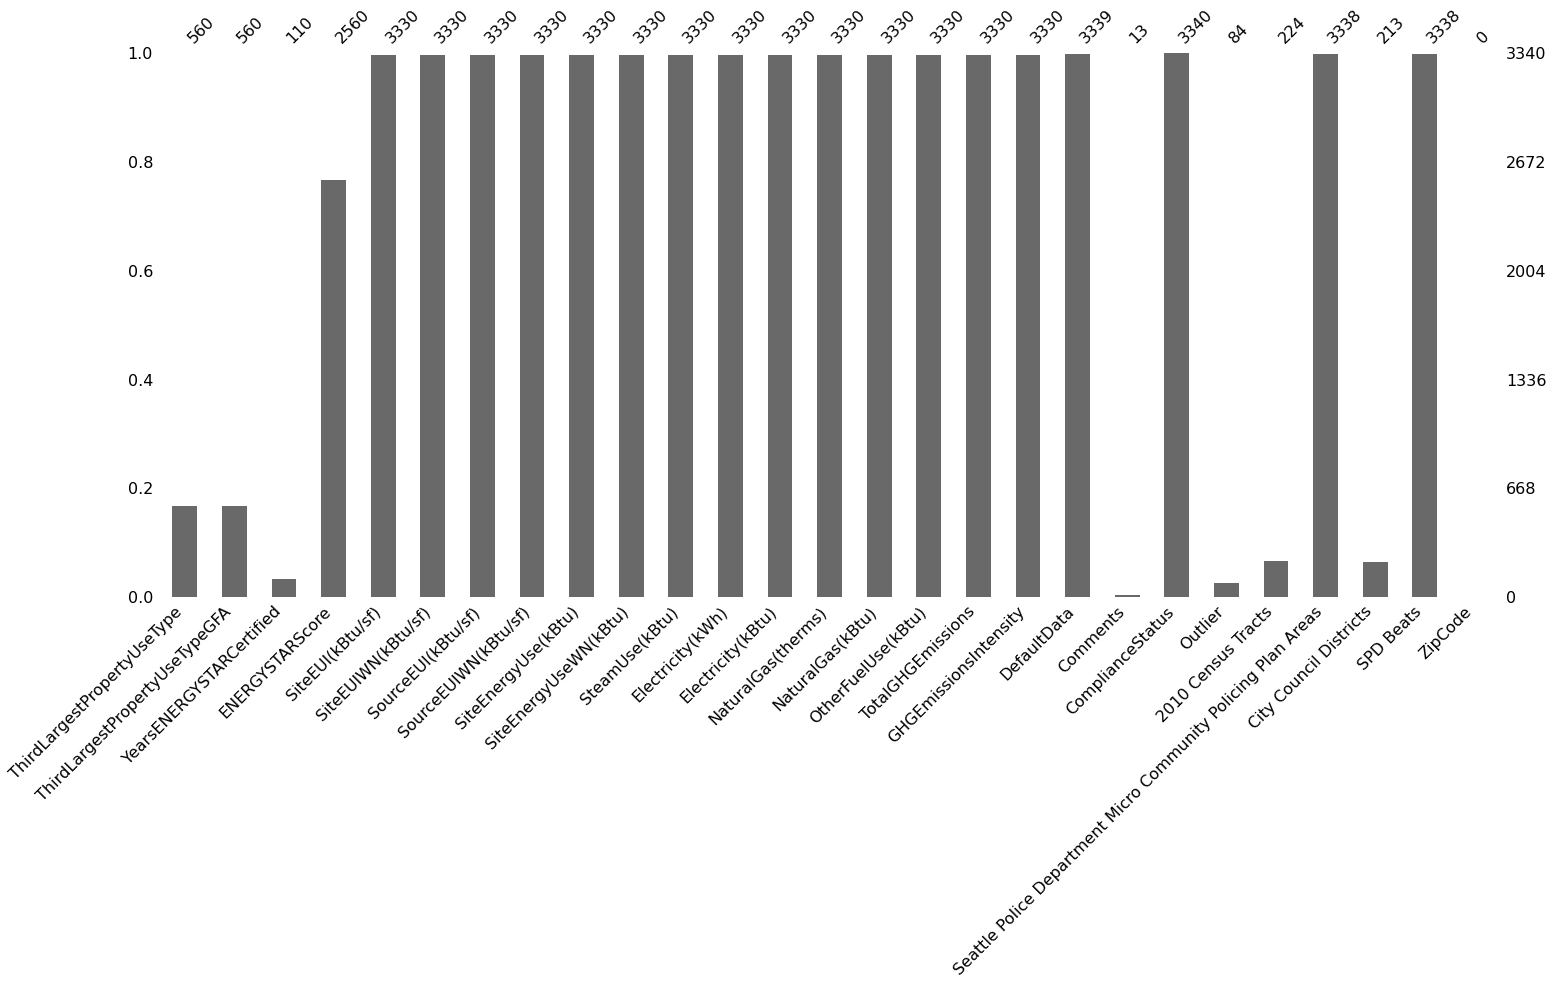

In [115]:
msno.bar(data2015[data2015.columns[25:]])

In [1543]:
missing = data2015.notna().sum()/data2015.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
Longitude                                                        1.000000
City                                                             1.000000
State                                                            1.000000
zip                                                              1.000000
CouncilDistrictCode                                              1.000000
Neighborhood                                                     1.000000
YearBuilt                                                        1.000000
NumberofBuildings                                                1.000000
PropertyGFATotal                                                 1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
Latitude                                                         1.000000
Address                               

<AxesSubplot:>

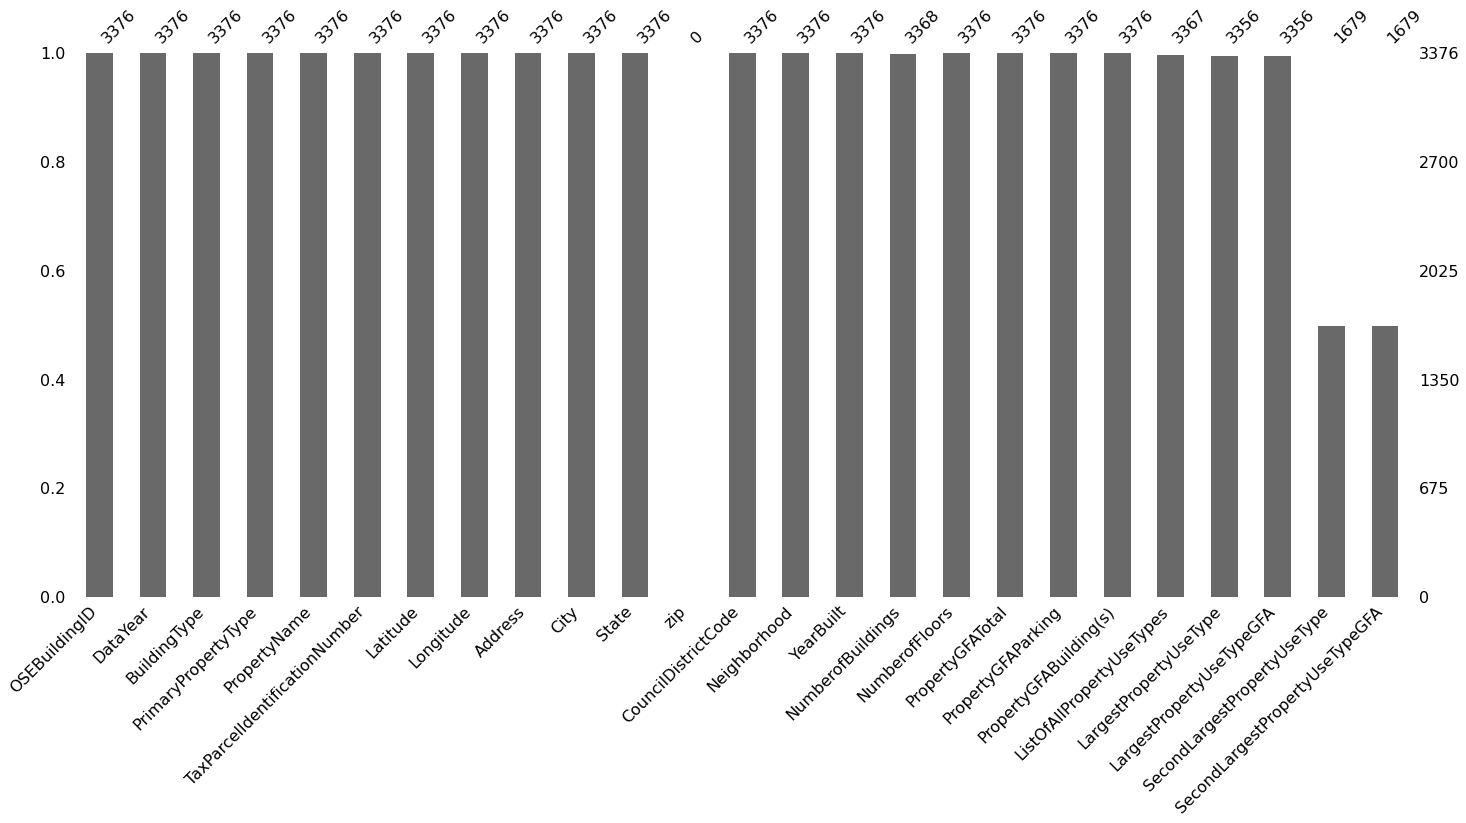

In [116]:
data2016 = raw_data[raw_data.DataYear==2016] 
msno.bar(data2016[data2016.columns[:25]])

In [1545]:
missing = data2016.notna().sum()/data2016.shape[0]
missing.sort_values(ascending=False)

OSEBuildingID                                                    1.000000
NumberofFloors                                                   1.000000
PropertyGFAParking                                               1.000000
PropertyGFABuilding(s)                                           1.000000
YearBuilt                                                        1.000000
Neighborhood                                                     1.000000
CouncilDistrictCode                                              1.000000
State                                                            1.000000
City                                                             1.000000
Address                                                          1.000000
Longitude                                                        1.000000
PropertyGFATotal                                                 1.000000
TaxParcelIdentificationNumber                                    1.000000
DataYear                              

On supprime les colonnes remplies à moins de 50%, à l'exception de la colonne "outliers" qu'on va inspecter ultérieurement.

In [126]:
missing = raw_data.notna().sum()/raw_data.shape[0]
missing = missing[missing<0.5].index

In [127]:
raw_data = raw_data.drop(columns=[c for c in missing if not c=="Outlier"]) 

<AxesSubplot:>

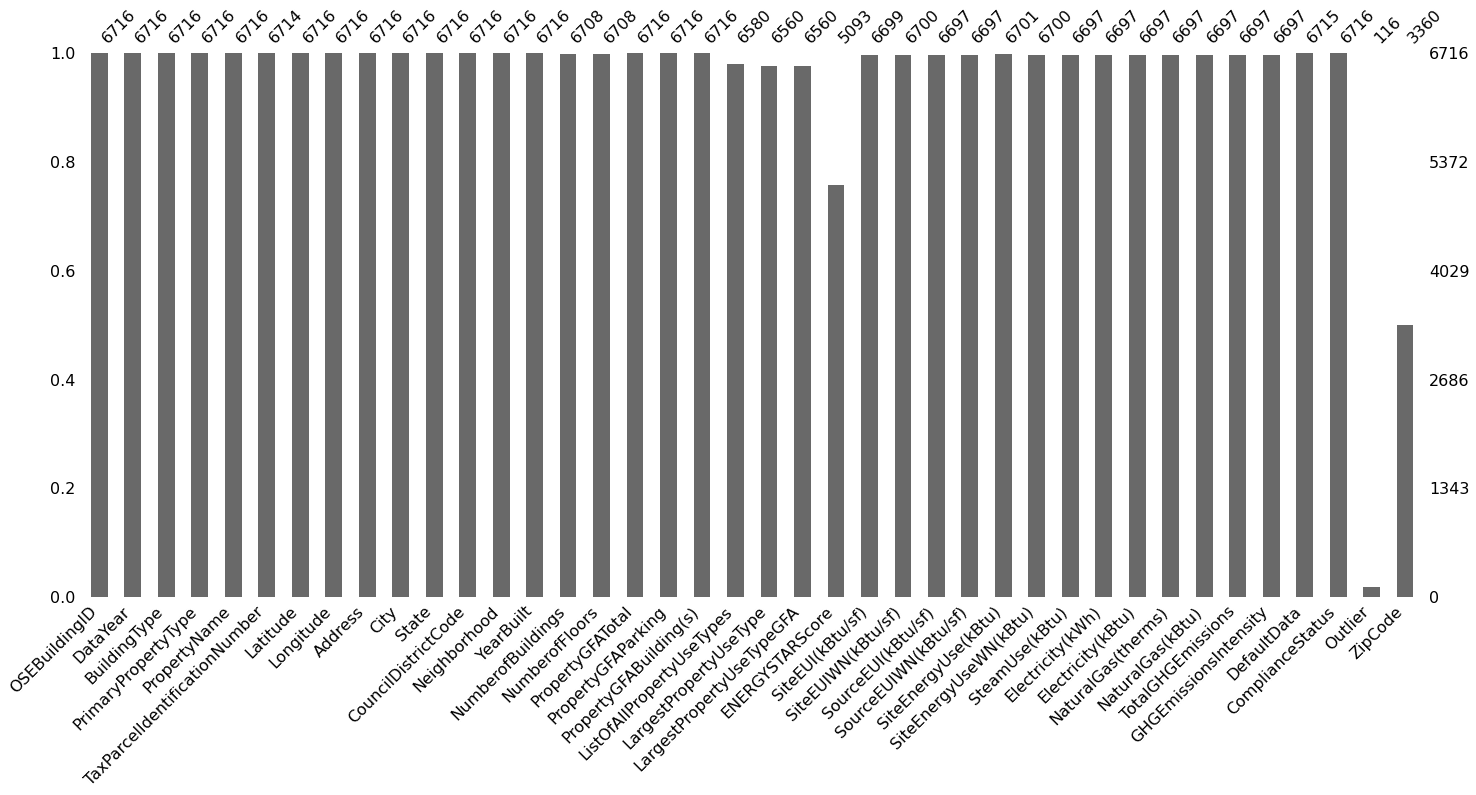

In [128]:
msno.bar(raw_data)

<AxesSubplot:>

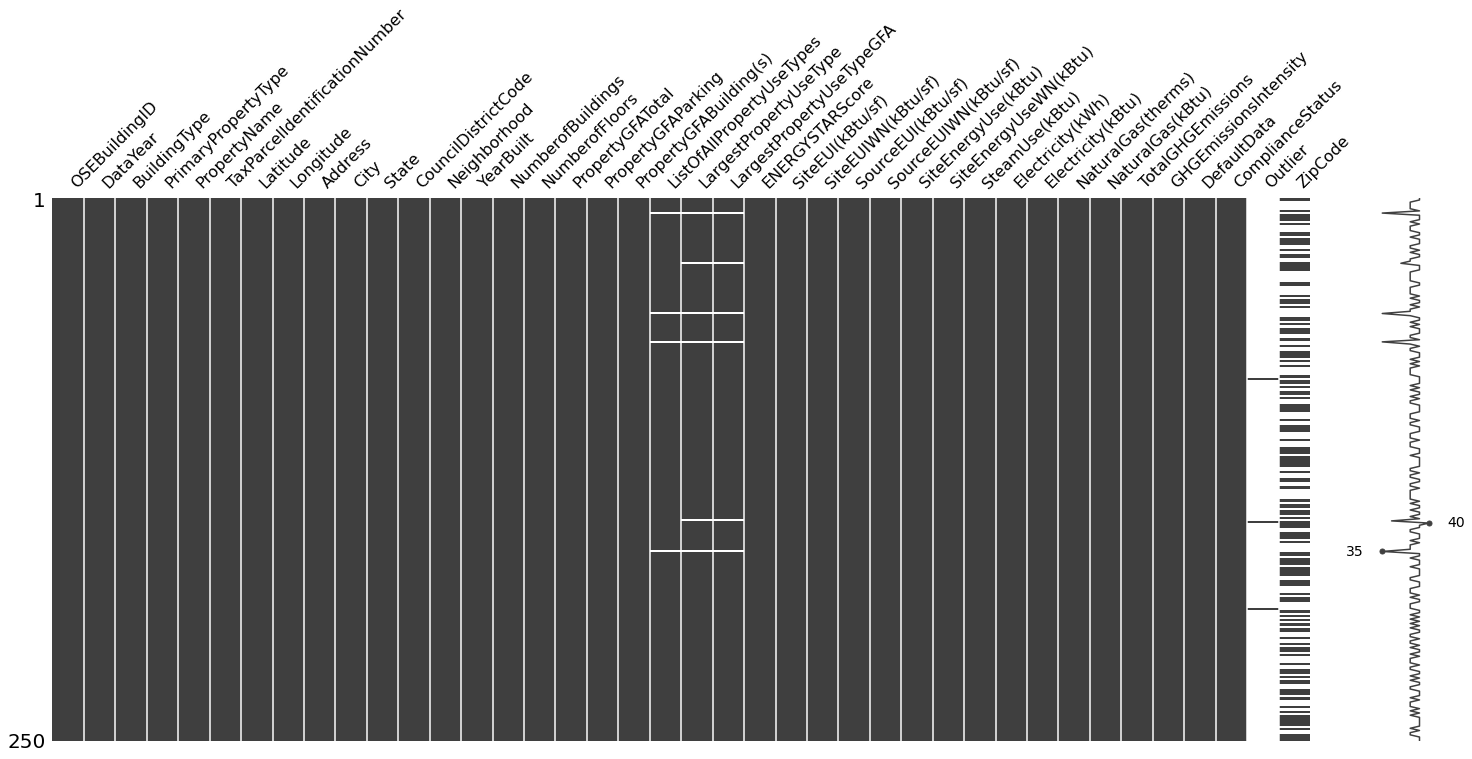

In [129]:
raw_data.dropna(subset=["ENERGYSTARScore"], how="any", inplace=True)
msno.matrix(raw_data.sample(250))

<AxesSubplot:>

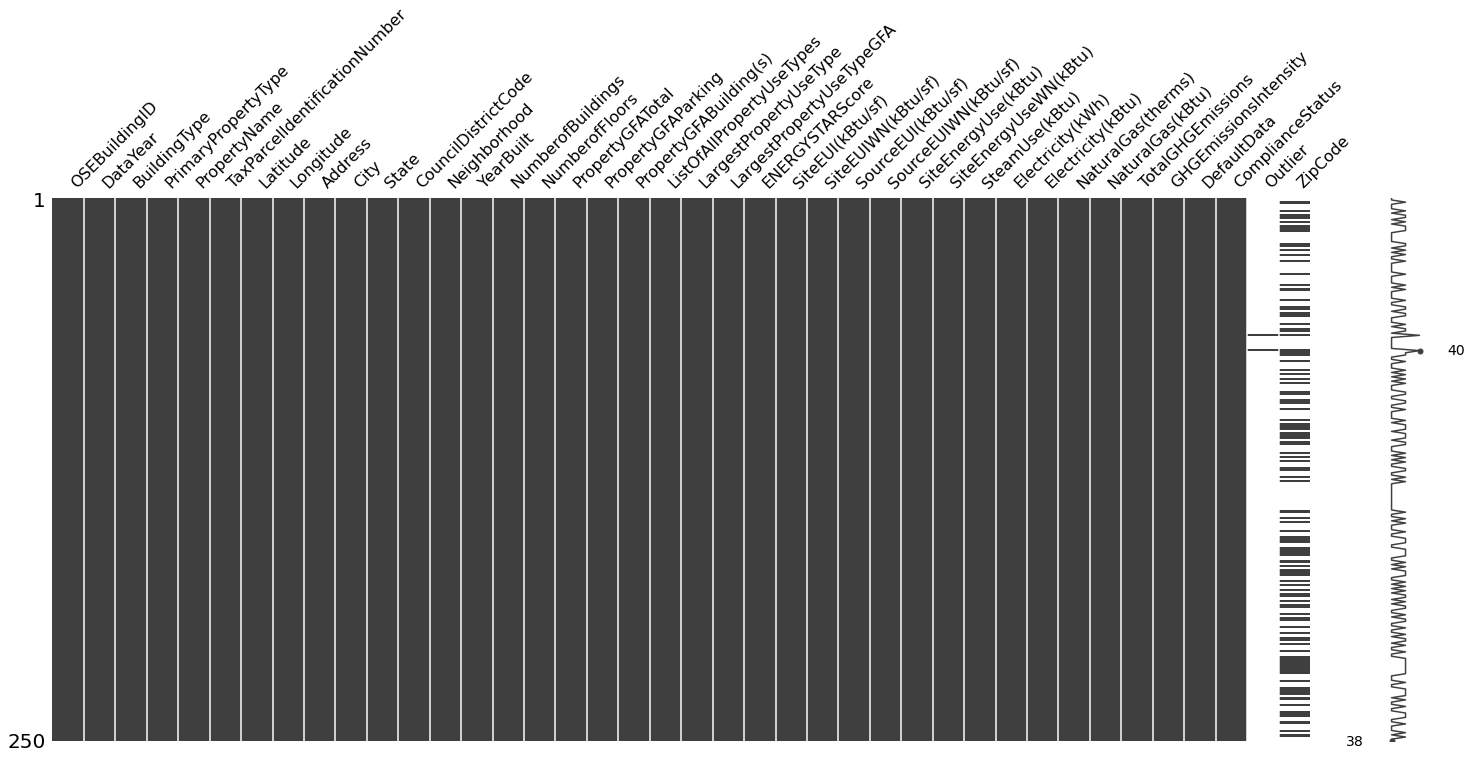

In [130]:
raw_data.dropna(subset=["ListOfAllPropertyUseTypes", 
                        "LargestPropertyUseType", 
                        "LargestPropertyUseTypeGFA"], how="all", inplace=True)

msno.matrix(raw_data.sample(250))

In [131]:
raw_data.dropna(subset=[c for c in raw_data.columns if not c in ["Outlier","ZipCode"]], how="any", inplace=True)

In [132]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 3371
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  4972 non-null   int64  
 1   DataYear                       4972 non-null   int64  
 2   BuildingType                   4972 non-null   object 
 3   PrimaryPropertyType            4972 non-null   object 
 4   PropertyName                   4972 non-null   object 
 5   TaxParcelIdentificationNumber  4972 non-null   object 
 6   Latitude                       4972 non-null   object 
 7   Longitude                      4972 non-null   object 
 8   Address                        4972 non-null   object 
 9   City                           4972 non-null   object 
 10  State                          4972 non-null   object 
 11  CouncilDistrictCode            4972 non-null   int64  
 12  Neighborhood                   4972 non-null   o

In [133]:
raw_data.to_csv("raw_data.csv", index_label=False)

# II. Analyse exploratoire

In [199]:
raw_data = pd.read_csv("./raw_data.csv")

## II.1 Variables qualitatives et variables quantitatives

**On sépare le dataframe en deux: les colonnes numériques et les colonnes "object"**

In [200]:
mask = raw_data.dtypes!="object"
numerical_features = mask[mask].index
numerical_features

Index(['OSEBuildingID', 'DataYear', 'Latitude', 'Longitude',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ZipCode'],
      dtype='object')

In [201]:
mask = raw_data.dtypes=="object"
categorical_features = mask[mask].index
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Address', 'City', 'State',
       'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'DefaultData', 'ComplianceStatus', 'Outlier'],
      dtype='object')

**On retire les colonnes OSEBuildingID, DataYear, CouncilDistrictCode, YearBuilt, Latitude, Longitude, ZipCode qui sont des variables catégorielles en réalité**

In [202]:
num_categorical = pd.Index(["OSEBuildingID", 
                 "DataYear", 
                 "CouncilDistrictCode", 
                 "YearBuilt", 
                 "Latitude",
                 "Longitude", 
                 "ZipCode"])

In [203]:
# On récupère ces colonnes dans la liste des indicateurs catégoriels
categorical_features = categorical_features.append(num_categorical)
categorical_features

Index(['BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'TaxParcelIdentificationNumber', 'Address', 'City', 'State',
       'Neighborhood', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'OSEBuildingID',
       'DataYear', 'CouncilDistrictCode', 'YearBuilt', 'Latitude', 'Longitude',
       'ZipCode'],
      dtype='object')

In [204]:
# On crée l'index quantitative_features qui ne contient que les variables quantitatives
quantitative_features = pd.Index([c for c in numerical_features if c not in categorical_features])
quantitative_features

Index(['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity'],
      dtype='object')

## II.2 Variables quantitatives

On souhaite se passer des relevés annuels. On doit donc arriver à faire des prédictions sur les variables "targets" sans les variables "SiteEUI, SiteEUIWN, SourceEUI, SourceEUIWN, SiteEnergyUseWN, SteamUse, Electricity, NaturalGas, GHGEmissionsIntensity".

In [310]:
# On exclut les indicateurs liés à l'énergie consommée dans la liste des indicateurs quantitatifs
quantitative_features = pd.Index(['NumberofBuildings',
                    'NumberofFloors', 
                    'PropertyGFATotal',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'LargestPropertyUseTypeGFA'])
targets = pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"])

### II.2.1 Distribution des variables quantitatives

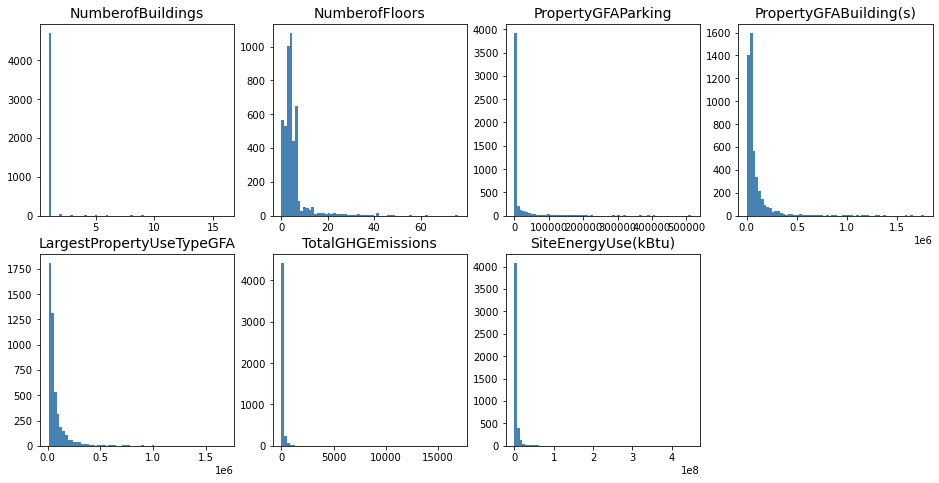

In [323]:
fig = plt.figure(figsize=(16, 12))
for feat_idx, feat in enumerate(quantitative_features.append(targets)):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(raw_data[feat], bins=5*int(1+np.log2(raw_data.shape[0])), color = 'steelblue', density=False, edgecolor='none')
    ax.set_title(feat, fontsize=14)

Données très dispersées. Echelles très différentes d'une variable à l'autre. On a des outliers. On a également des valeurs à 0 (NumberofBuildings, TotalGHGEmission, LargestPropertyUseTypeGFA etc.) Surement des valeurs aberrantes.  On vérifie.

In [207]:
for feat in quantitative_features.append(targets):
    print(raw_data[feat].describe(percentiles=[0.5]))
    print("-"*40)

count    4972.000000
mean        1.024940
std         0.438287
min         0.000000
50%         1.000000
max        16.000000
Name: NumberofBuildings, dtype: float64
----------------------------------------
count    4972.000000
mean        5.064360
std         6.011077
min         0.000000
50%         4.000000
max        99.000000
Name: NumberofFloors, dtype: float64
----------------------------------------
count    4.972000e+03
mean     9.512040e+04
std      1.509916e+05
min      1.229400e+04
50%      4.616050e+04
max      1.952220e+06
Name: PropertyGFATotal, dtype: float64
----------------------------------------
count      4972.000000
mean       9999.018302
std       34146.815421
min          -3.000000
50%           0.000000
max      512608.000000
Name: PropertyGFAParking, dtype: float64
----------------------------------------
count    4.972000e+03
mean     8.512138e+04
std      1.307355e+05
min     -4.331000e+04
50%      4.435200e+04
max      1.765970e+06
Name: PropertyGFABuilding

Confirmation de l'observation précédente: valeurs aberrantes (surfaces négatives), très dispersées (std >= moyenne), présence probable d'outliers (max >> {moyenne, mediane}). Distribution non-normales.

### II.2.2 outliers

On utilise la colonne "Outlier"

In [208]:
raw_data["Outlier"].head()

0             NaN
1             NaN
2             NaN
3    High Outlier
4             NaN
Name: Outlier, dtype: object

In [209]:
raw_data["Outlier"].unique()

array([nan, 'High Outlier', 'Low Outlier', 'Low outlier', 'High outlier'],
      dtype=object)

In [210]:
raw_data["Outlier"].value_counts()

High Outlier    34
Low Outlier     33
Low outlier     17
High outlier     6
Name: Outlier, dtype: int64

In [211]:
# Pour la visualisation, on regroupe tous les outliers dans la catégorie "Yes", et les valeurs NaN dans "No"
outlier_yn = raw_data["Outlier"].where(raw_data["Outlier"].notna(), "No")
raw_data["Outlier_yn"] = outlier_yn

raw_data["Outlier_yn"] = raw_data["Outlier_yn"].apply(lambda x: "Yes" if x!="No" else x)

In [212]:
raw_data["Outlier_yn"].value_counts()

No     4882
Yes      90
Name: Outlier_yn, dtype: int64

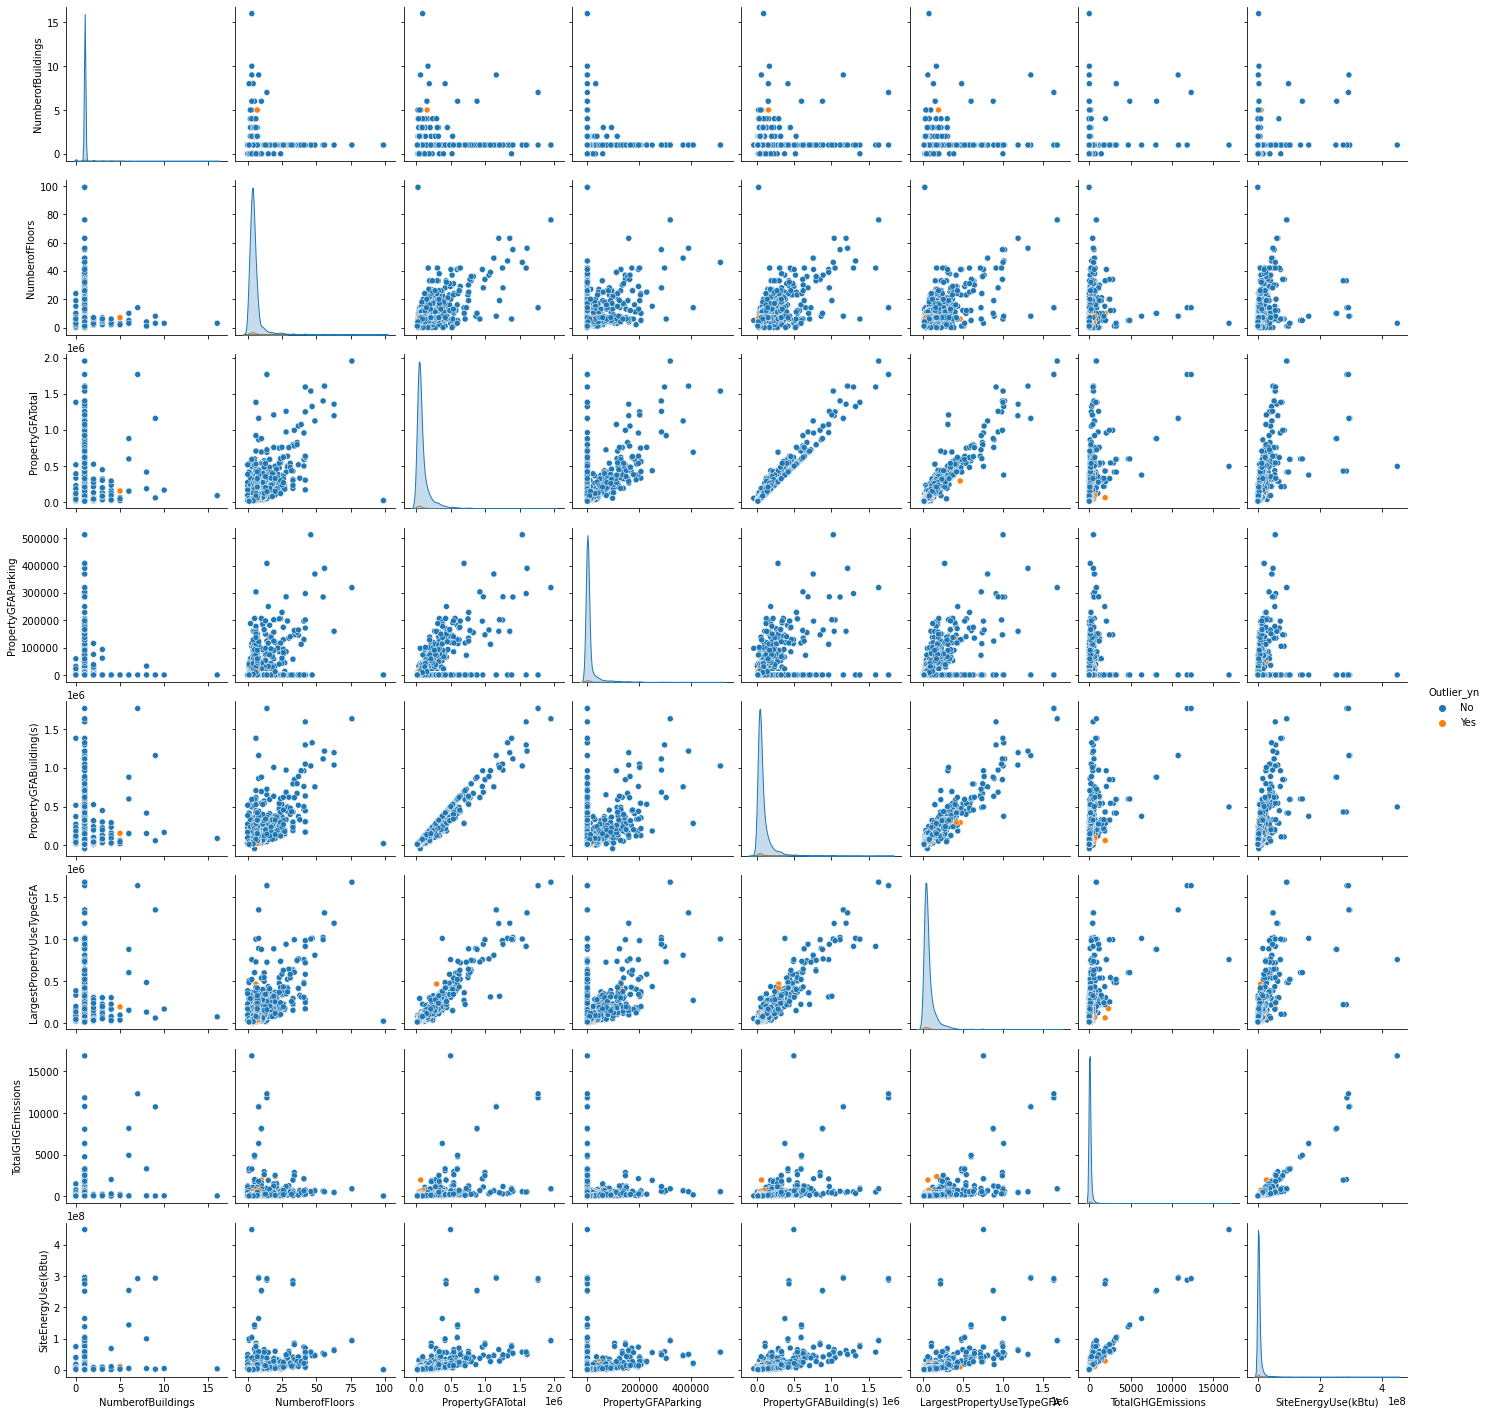

In [191]:
feats = quantitative_features.append(pd.Index(np.concatenate((["Outlier_yn"], targets))))
sns.pairplot(raw_data[feats], diag_kind="kde", hue="Outlier_yn")

In [213]:
# On corrige la valeur de PropertyGFABuilding(s)
m = raw_data["PropertyGFABuilding(s)"] <= 0
raw_data["PropertyGFABuilding(s)"].mask(m, -raw_data["PropertyGFABuilding(s)"], inplace=True)

# On retire les valeurs de TotalGHGEmissions et NumberofBuildings qui sont négatives ou nulles
d = raw_data.query("TotalGHGEmissions<=0 or NumberofBuildings<=0").index
raw_data.drop(index=d, inplace=True)

In [214]:
# On exclut les outliers
raw_data = raw_data.loc[raw_data.Outlier_yn=="No"]
raw_data = raw_data[raw_data.NumberofFloors<80] # Il y a un bâtiment de 99 étages dont les émissions sont quasi-nulles

In [215]:
raw_data.Outlier_yn.value_counts()

No    4775
Name: Outlier_yn, dtype: int64

In [216]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 3371
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  4775 non-null   int64  
 1   DataYear                       4775 non-null   int64  
 2   BuildingType                   4775 non-null   object 
 3   PrimaryPropertyType            4775 non-null   object 
 4   PropertyName                   4775 non-null   object 
 5   TaxParcelIdentificationNumber  4775 non-null   object 
 6   Latitude                       4775 non-null   float64
 7   Longitude                      4775 non-null   float64
 8   Address                        4775 non-null   object 
 9   City                           4775 non-null   object 
 10  State                          4775 non-null   object 
 11  CouncilDistrictCode            4775 non-null   int64  
 12  Neighborhood                   4775 non-null   o

In [217]:
# On supprime la colonne "Outlier"
raw_data.drop(columns="Outlier", inplace=True)

In [305]:
raw_data.index = pd.Index(range(0, raw_data.shape[0]))
raw_data.to_csv("./data.csv", index_label=False)
data = raw_data

## II.2.3 Transformation des variables cibles

On remplace les variables targets par leur log.

In [512]:
data = pd.read_csv("./data.csv")

In [513]:
data["SiteEnergyUse_log"] = data["SiteEnergyUse(kBtu)"].apply(np.log10)
data["TotalGHGEmissions_log"] = data["TotalGHGEmissions"].apply(np.log10)
targets = pd.Index(["SiteEnergyUse_log", "TotalGHGEmissions_log"])

<AxesSubplot:>

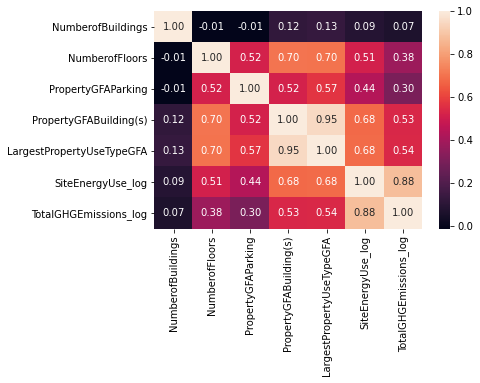

In [307]:
corr = data[quantitative_features.append(targets)].corr()
sns.heatmap(corr, annot=True, fmt=".2f")

## II.2.4 Suppression de PropertyGFATotal

PropertyGFATotal semble être la somme de PropertyGFAParking et PropertyGFABuilding(s).

<AxesSubplot:ylabel='PropertyGFATotal'>

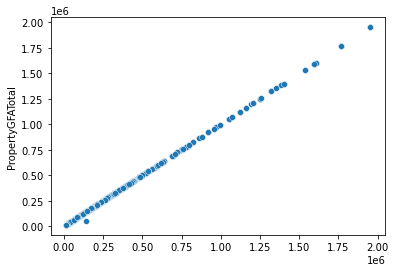

In [222]:
sum_pgfa = data.loc[:, ["PropertyGFABuilding(s)", "PropertyGFAParking"]].apply(np.sum, axis=1)
tot_pgfa = data.PropertyGFATotal

sns.scatterplot(x=sum_pgfa, y=tot_pgfa)

On n'utilisera pas PropertyGFATotal

In [514]:
data.drop(columns="PropertyGFATotal", inplace=True)

In [403]:
quantitative_features = quantitative_features.drop("PropertyGFATotal")

KeyError: "['PropertyGFATotal'] not found in axis"

## II.2.5 Corrélations des variables quantitatives

Pour chaque target, on va trier les variables de la plus corrélée à la moins corrélée

In [225]:
data[quantitative_features.append(pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]))].corr()["TotalGHGEmissions"].sort_values(ascending=False)

TotalGHGEmissions            1.000000
SiteEnergyUse(kBtu)          0.907853
LargestPropertyUseTypeGFA    0.547168
PropertyGFABuilding(s)       0.490516
NumberofBuildings            0.237827
NumberofFloors               0.183248
PropertyGFAParking           0.099713
Name: TotalGHGEmissions, dtype: float64

In [226]:
data[quantitative_features.append(targets)].corr()["TotalGHGEmissions_log"].sort_values(ascending=False)

TotalGHGEmissions_log        1.000000
SiteEnergyUse_log            0.879462
LargestPropertyUseTypeGFA    0.539875
PropertyGFABuilding(s)       0.533690
NumberofFloors               0.382367
PropertyGFAParking           0.300721
NumberofBuildings            0.067524
Name: TotalGHGEmissions_log, dtype: float64

In [227]:
data[quantitative_features.append(pd.Index(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]))].corr()["SiteEnergyUse(kBtu)"].sort_values(ascending=False)

SiteEnergyUse(kBtu)          1.000000
TotalGHGEmissions            0.907853
LargestPropertyUseTypeGFA    0.676874
PropertyGFABuilding(s)       0.641223
NumberofFloors               0.368363
PropertyGFAParking           0.259094
NumberofBuildings            0.206377
Name: SiteEnergyUse(kBtu), dtype: float64

In [228]:
data[quantitative_features.append(targets)].corr()["SiteEnergyUse_log"].sort_values(ascending=False)

SiteEnergyUse_log            1.000000
TotalGHGEmissions_log        0.879462
LargestPropertyUseTypeGFA    0.683959
PropertyGFABuilding(s)       0.682619
NumberofFloors               0.513785
PropertyGFAParking           0.437968
NumberofBuildings            0.086973
Name: SiteEnergyUse_log, dtype: float64

Les variables cibles sont légèrement moins corrélées entre elles lorsqu'on considère leur log. Elles sont également moins corrélées à la variable "NumberofBuildings". On a en revanche augmenté la corrélation linéaire avec les autres variables quantitatives.

In [229]:
feats = ["TotalGHGEmissions", "SiteEnergyUse(kBtu)", "NumberofBuildings"]
feats_log = ["TotalGHGEmissions_log", "SiteEnergyUse_log", "NumberofBuildings"]

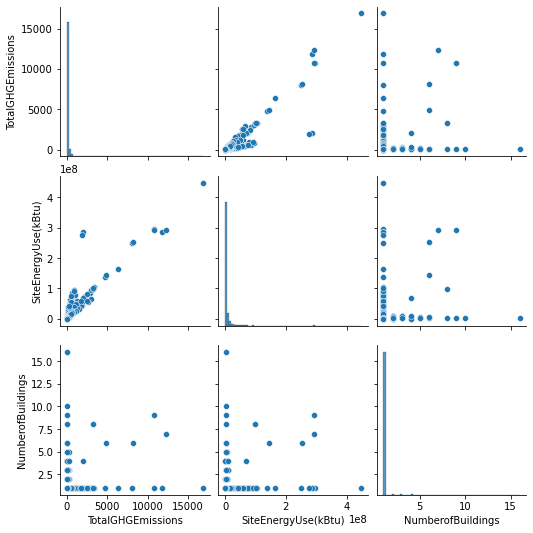

In [322]:
sns.pairplot(data[feats], diag_kind="hist", diag_kws={"bins":5*int(1+np.log2(raw_data.shape[0]))})

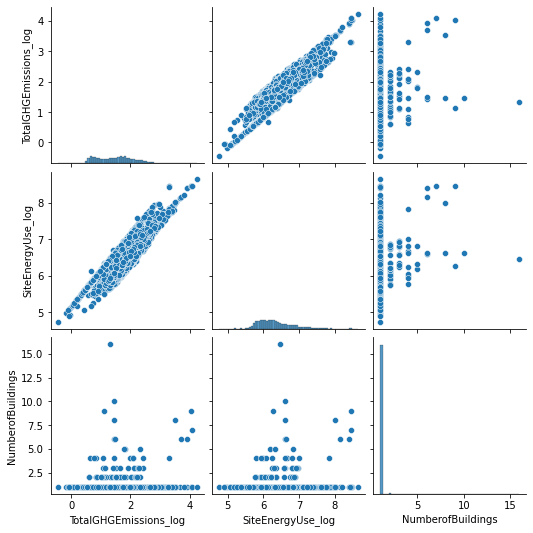

In [321]:
sns.pairplot(data[feats_log], diag_kind="hist", diag_kws = {'bins':5*int(1+np.log2(raw_data.shape[0]))})

Sans doute la corrélation linéaire est-elle trompeuse ici. La plus forte corrélation entre les variables cibles (et non sur leur log) suggère de ne pas utiliser le log pour prédire l'une à partir de l'autre.

Distribution bi-modale pour TotalGHGEmissions. NumberofBuildings largement dominée par les entités comprenant 1 ou 2 bâtiments.

Pour la variable NumberofBuildings, on va plutôt afficher les diagrammes en boîte.

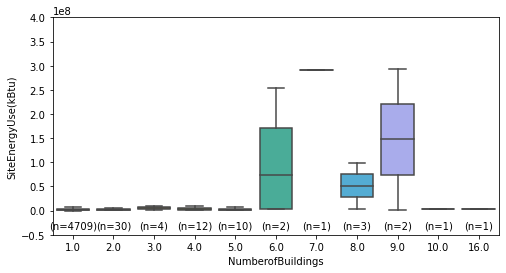

In [265]:
# affichage des effectifs de chaque classe
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x="NumberofBuildings", y="SiteEnergyUse(kBtu)", data=data, ax=ax, showfliers=False)
ax.set_ylim([-5e7, 4e8])
for pos, g in enumerate(data["NumberofBuildings"].unique()):
    y= data.loc[data["NumberofBuildings"]==g, "SiteEnergyUse(kBtu)"].quantile(0.75)
    ax.text(pos, -2e7,"(n={})".format(data[data["NumberofBuildings"]==g].shape[0]),horizontalalignment='center',verticalalignment='top')
plt.show()

Le passage au log va nous permettre d'obtenir une meilleure visualisation

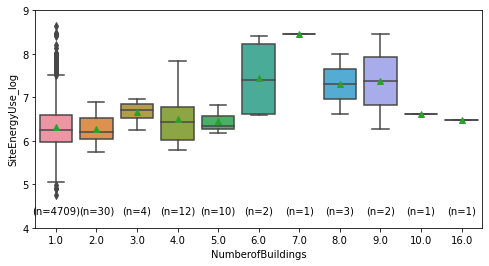

In [275]:
# affichage des effectifs de chaque classe
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x="NumberofBuildings", y="SiteEnergyUse_log", data=data, ax=ax, showfliers=True, showmeans=True)
ax.set_ylim([4, 9])
for pos, g in enumerate(data["NumberofBuildings"].unique()):
    y= data.loc[data["NumberofBuildings"]==g, "SiteEnergyUse_log"].quantile(0.75)
    ax.text(pos, 4.5,"(n={})".format(data[data["NumberofBuildings"]==g].shape[0]),horizontalalignment='center',verticalalignment='top')
plt.show()

### II.3 Variables catégorielles

### II.3.1 Tour d'horizon des variables catégorielles

In [38]:
cat_feats = pd.DataFrame(data={"nombre de modalités":data[categorical_features].nunique()})
cat_feats

,nombre de modalités
BuildingType,7
PrimaryPropertyType,25
PropertyName,4738
TaxParcelIdentificationNumber,2825
Address,4656
City,2
State,1
Neighborhood,18
ListOfAllPropertyUseTypes,236
LargestPropertyUseType,26


Variables d'intérêt: DataYear, BuildingType, PrimaryPropertyType, LargestPropertyUseType, YearBuilt, ListOfAllPropertyUseTypes

In [39]:
data.BuildingType.head()

0    NonResidential
1    NonResidential
2    NonResidential
3    NonResidential
4    NonResidential
Name: BuildingType, dtype: object

In [40]:
data.LargestPropertyUseType.head()

0    Hotel
1    Hotel
2    Hotel
3    Hotel
4    Hotel
Name: LargestPropertyUseType, dtype: object

In [41]:
data.PrimaryPropertyType.head()

0    Hotel
1    Hotel
2    Hotel
3    Hotel
4    Hotel
Name: PrimaryPropertyType, dtype: object

In [42]:
data.YearBuilt.head()

0    1927
1    1996
2    1969
3    1926
4    1980
Name: YearBuilt, dtype: int64

In [325]:
data.ListOfAllPropertyUseTypes

0                               Hotel
1          Hotel, Parking, Restaurant
2       Hotel, Parking, Swimming Pool
3       Hotel, Parking, Swimming Pool
4                               Hotel
                    ...              
4770     Multifamily Housing, Parking
4771              Multifamily Housing
4772                           Office
4773                           Office
4774                           Office
Name: ListOfAllPropertyUseTypes, Length: 4775, dtype: object

Doublons entre LargestPropertyUseType et PrimaryPropertyType?

In [43]:
data.LargestPropertyUseType.unique()

array(['Hotel', 'Multifamily Housing', 'Courthouse', 'K-12 School',
       'Self-Storage Facility', 'Office', 'Senior Care Community',
       'Retail Store', 'Hospital (General Medical & Surgical)',
       'Residence Hall/Dormitory', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Worship Facility', 'Medical Office',
       'Supermarket/Grocery Store', 'Parking', 'Distribution Center',
       'Wholesale Club/Supercenter', 'Refrigerated Warehouse',
       'Data Center', 'Other - Public Services', 'Bank Branch',
       'Laboratory', 'Manufacturing/Industrial Plant',
       'Other - Restaurant/Bar', 'Other'], dtype=object)

In [326]:
data.PrimaryPropertyType.unique()

array(['Hotel', 'Mid-Rise Multifamily', 'Other', 'K-12 School',
       'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
       'Large Office', 'Low-Rise Multifamily', 'Senior Care Community',
       'Retail Store', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Worship Facility', 'Medical Office',
       'Supermarket/Grocery Store', 'Mixed Use Property',
       'Distribution Center', 'Refrigerated Warehouse',
       'High-Rise Multifamily', 'Residence Hall', 'Warehouse', 'Office'],
      dtype=object)

Sans doute des doublons. On va fusionner ces deux variables, et ne garder que les modalités uniques. On peut regarder les corrélations entre les modalités.

### II.3.2 Etude des corrélations

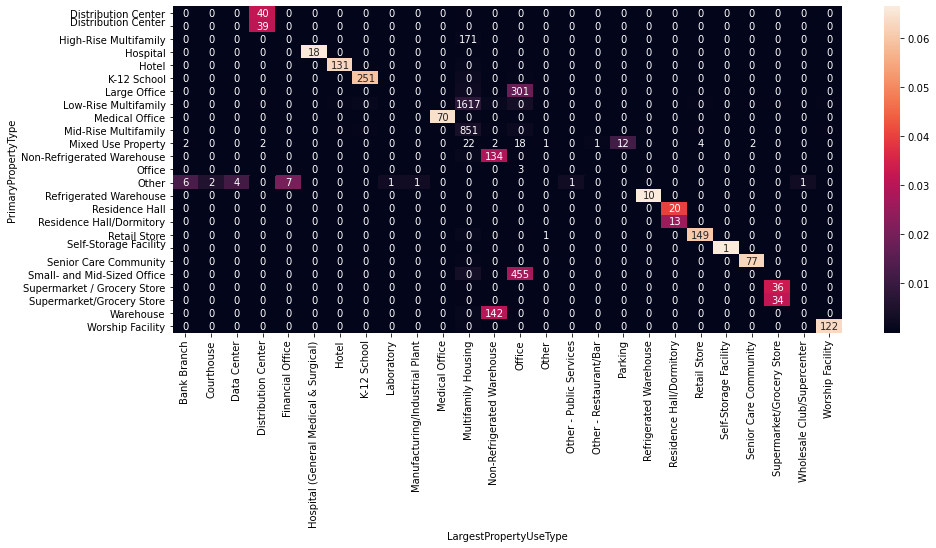

In [312]:
def contingence(Var1, Var2, df):
    X=Var1
    Y=Var2
    cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

    tx = cont.loc[:,["Total"]]
    ty = cont.loc[["Total"],:]
    n = len(df)
    indep = tx.dot(ty) / n

    c = cont.fillna(0) # On remplace les valeurs nulles par 0
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    plt.figure(figsize=(15, 6))
    sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1], fmt=".0f")

contingence("PrimaryPropertyType", "LargestPropertyUseType", data)

Les variables PrimaryPropertyType et LargestPropertyUseType sont très semblables. Il y a deux modalités associées à "Distribution Center" dans la variable PrimaryPropertyType?

In [277]:
data["PrimaryPropertyType"].unique()

array(['Hotel', 'Mid-Rise Multifamily', 'Other', 'K-12 School',
       'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
       'Large Office', 'Low-Rise Multifamily', 'Senior Care Community',
       'Retail Store', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Worship Facility', 'Medical Office',
       'Supermarket/Grocery Store', 'Mixed Use Property',
       'Distribution Center\n', 'Refrigerated Warehouse',
       'High-Rise Multifamily', 'Residence Hall', 'Warehouse',
       'Supermarket / Grocery Store', 'Distribution Center', 'Office'],
      dtype=object)

On corrige... On en profite pour corriger aussi les deux "fausses" modalités associées à "Supermarket/Grocery Store"

In [515]:
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Distribution Center" 
                                                             if "Distribution Center" in x else x)

data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Supermarket/Grocery Store"
                                 if "Grocery Store" in x else x)

In [516]:
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Self-Storage Facility"
                                                               if "Self-Storage" in x else x)

In [517]:
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Non-Refrigerated Warehouse"
                                                               if x=="Warehouse" else x)

In [292]:
data["PrimaryPropertyType"].unique()

array(['Hotel', 'Mid-Rise Multifamily', 'Other', 'K-12 School',
       'Self-Storage Facility\n', 'Small- and Mid-Sized Office',
       'Large Office', 'Low-Rise Multifamily', 'Senior Care Community',
       'Retail Store', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Worship Facility', 'Medical Office',
       'Supermarket/Grocery Store', 'Mixed Use Property',
       'Distribution Center', 'Refrigerated Warehouse',
       'High-Rise Multifamily', 'Residence Hall', 'Warehouse', 'Office'],
      dtype=object)

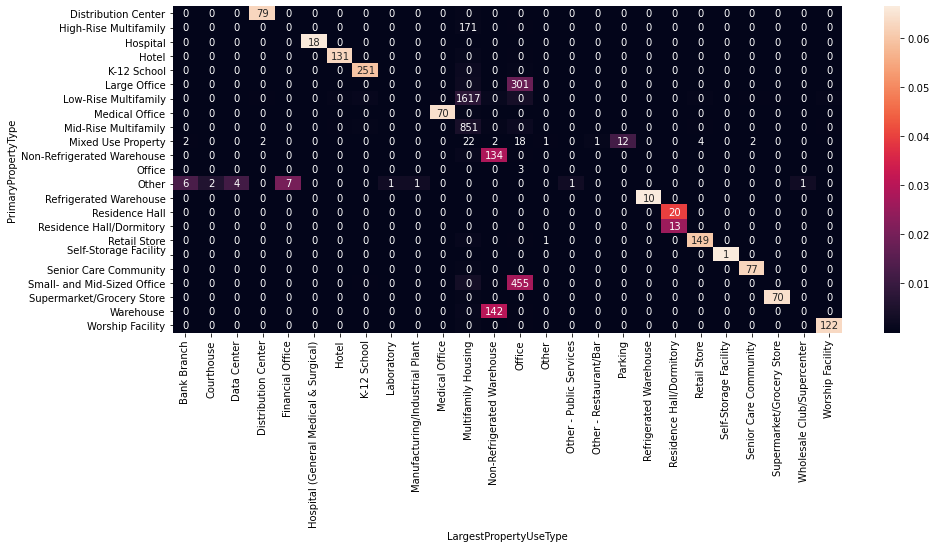

In [314]:
contingence("PrimaryPropertyType", "LargestPropertyUseType", data)

Residence Hall vs Residence Hall/Dormitory?

In [315]:
print(data.loc[data.DataYear==2015, "PrimaryPropertyType"].unique())
print(data.loc[data.DataYear==2016, "PrimaryPropertyType"].unique())

['Hotel' 'Mid-Rise Multifamily' 'Other' 'K-12 School'
 'Self-Storage Facility\n' 'Small- and Mid-Sized Office' 'Large Office'
 'Low-Rise Multifamily' 'Senior Care Community' 'Retail Store' 'Hospital'
 'Residence Hall/Dormitory' 'Non-Refrigerated Warehouse'
 'Worship Facility' 'Medical Office' 'Supermarket/Grocery Store'
 'Mixed Use Property' 'Distribution Center' 'Refrigerated Warehouse'
 'High-Rise Multifamily']
['Hotel' 'Mid-Rise Multifamily' 'Other' 'K-12 School' 'Mixed Use Property'
 'Small- and Mid-Sized Office' 'Large Office' 'Senior Care Community'
 'Retail Store' 'Hospital' 'Residence Hall' 'Warehouse' 'Worship Facility'
 'Low-Rise Multifamily' 'Medical Office' 'Supermarket/Grocery Store'
 'Distribution Center' 'Refrigerated Warehouse' 'High-Rise Multifamily'
 'Office']


Il semble que Reseidence Hall et Residence Hall/Dormitory représentent la même chose. Comment le confirmer?

On va grouper les YearBuilt par décennies, et regarder la distribution de chacune de ces variables, ainsi que de la variable Residence Hall/Dormitory provenant de LArgestPropertyUseType sur les différentes décennies.

In [428]:
slice = 10 # décennies
bins = [1900+i*slice for i in range(13)]
yb_grouped = np.digitize(data.YearBuilt, bins)
yb_grouped = pd.Series(data=yb_grouped, name="yb_grouped")

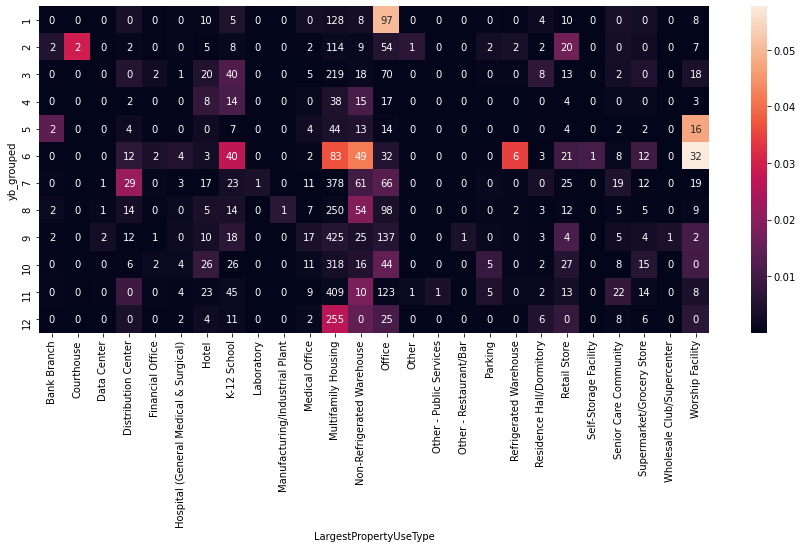

In [429]:
df = pd.concat([data, yb_grouped], axis=1)
contingence("yb_grouped", "LargestPropertyUseType", df)

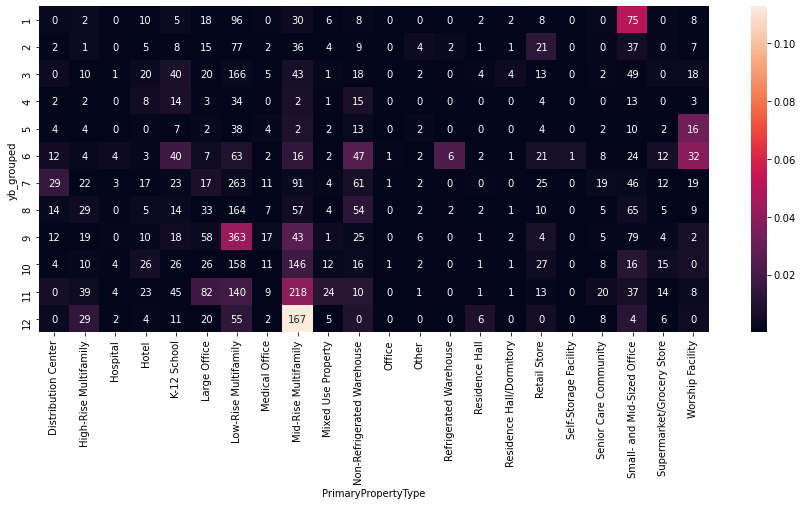

In [430]:
contingence("yb_grouped", "PrimaryPropertyType", df)

Cela confirme que Residence Hall et Residence Hall/Dormitory représentent la même chose.

Nettoyage

In [518]:
data["PrimaryPropertyType"] = data["PrimaryPropertyType"].apply(lambda x: "Residence Hall/Dormitory"
                                 if "Residence Hall" in x else x)

On peut maintenant fusionner les modalités identiques. Pour cela, on va One-hot encoder les deux variables, "LargestPropertyUseType" et "PrimaryPropertyType", puis retirer les colonnes en double.

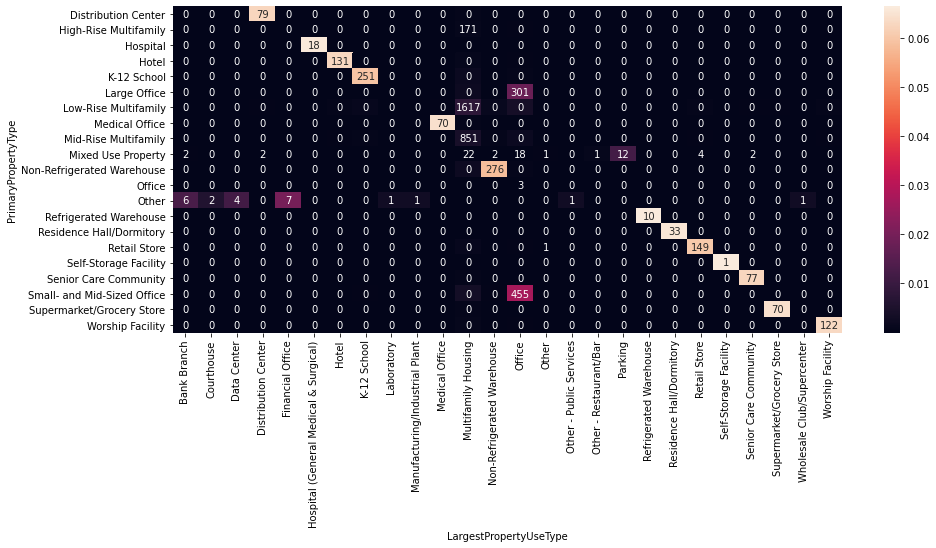

In [519]:
contingence("PrimaryPropertyType", "LargestPropertyUseType", data)

In [525]:
largestptype = pd.get_dummies(data.LargestPropertyUseType, prefix="largest")
primaryptype = pd.get_dummies(data.PrimaryPropertyType, prefix="primary")

ptype = pd.concat([largestptype, primaryptype], axis=1)

In [526]:
pd.Series(ptype.columns)

0                               largest_Bank Branch
1                                largest_Courthouse
2                               largest_Data Center
3                       largest_Distribution Center
4                          largest_Financial Office
5     largest_Hospital (General Medical & Surgical)
6                                     largest_Hotel
7                               largest_K-12 School
8                                largest_Laboratory
9            largest_Manufacturing/Industrial Plant
10                           largest_Medical Office
11                      largest_Multifamily Housing
12               largest_Non-Refrigerated Warehouse
13                                   largest_Office
14                                    largest_Other
15                  largest_Other - Public Services
16                   largest_Other - Restaurant/Bar
17                                  largest_Parking
18                   largest_Refrigerated Warehouse
19          

In [528]:
ptypes = ptype.T.drop_duplicates().T
ptypes.columns

Index(['largest_Bank Branch', 'largest_Courthouse', 'largest_Data Center',
       'largest_Distribution Center', 'largest_Financial Office',
       'largest_Hospital (General Medical & Surgical)', 'largest_Hotel',
       'largest_K-12 School', 'largest_Laboratory',
       'largest_Manufacturing/Industrial Plant', 'largest_Medical Office',
       'largest_Multifamily Housing', 'largest_Non-Refrigerated Warehouse',
       'largest_Office', 'largest_Other', 'largest_Other - Public Services',
       'largest_Other - Restaurant/Bar', 'largest_Parking',
       'largest_Refrigerated Warehouse', 'largest_Residence Hall/Dormitory',
       'largest_Retail Store', 'largest_Self-Storage Facility',
       'largest_Senior Care Community', 'largest_Supermarket/Grocery Store',
       'largest_Wholesale Club/Supercenter', 'largest_Worship Facility',
       'primary_Distribution Center', 'primary_High-Rise Multifamily',
       'primary_Large Office', 'primary_Low-Rise Multifamily',
       'primary_Mid-R

In [529]:
ptypes.drop(columns=["largest_Multifamily Housing", "primary_Office", "primary_Other"], inplace=True)
ptypes.head()

,largest_Bank Branch,largest_Courthouse,largest_Data Center,largest_Distribution Center,largest_Financial Office,largest_Hospital (General Medical & Surgical),largest_Hotel,largest_K-12 School,largest_Laboratory,largest_Manufacturing/Industrial Plant,...,primary_Distribution Center,primary_High-Rise Multifamily,primary_Large Office,primary_Low-Rise Multifamily,primary_Mid-Rise Multifamily,primary_Mixed Use Property,primary_Non-Refrigerated Warehouse,primary_Retail Store,primary_Senior Care Community,primary_Small- and Mid-Sized Office
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
largestputype = ptypes[]

In [432]:
data = pd.concat([data, ptypes], axis=1)
data.drop(columns=["LargestPropertyUseType", "PrimaryPropertyType"], inplace=True)

In [433]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 76 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   OSEBuildingID                          4775 non-null   int64  
 1   DataYear                               4775 non-null   int64  
 2   BuildingType                           4775 non-null   object 
 3   PropertyName                           4775 non-null   object 
 4   TaxParcelIdentificationNumber          4775 non-null   object 
 5   Latitude                               4775 non-null   float64
 6   Longitude                              4775 non-null   float64
 7   Address                                4775 non-null   object 
 8   City                                   4775 non-null   object 
 9   State                                  4775 non-null   object 
 10  CouncilDistrictCode                    4775 non-null   int64  
 11  Neig

In [447]:
data.to_csv("./data_mergedptypes.csv", index_label=False)

# III Modèles Linéaires

In [483]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [467]:
data = pd.read_csv("./data_mergedptypes.csv")

In [468]:
# Sélection des variables
features = np.concatenate((data.columns[1:3], 
                           data.columns[12:17],
                           data.columns[18:19],
                           data.columns[37:38], 
                           data.columns[39:]))
data = data[features]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   DataYear                               4775 non-null   int64  
 1   BuildingType                           4775 non-null   object 
 2   YearBuilt                              4775 non-null   int64  
 3   NumberofBuildings                      4775 non-null   float64
 4   NumberofFloors                         4775 non-null   float64
 5   PropertyGFAParking                     4775 non-null   int64  
 6   PropertyGFABuilding(s)                 4775 non-null   int64  
 7   LargestPropertyUseTypeGFA              4775 non-null   float64
 8   SiteEnergyUse_log                      4775 non-null   float64
 9   Bank Branch                            4775 non-null   int64  
 10  Courthouse                             4775 non-null   int64  
 11  Data

In [460]:
data[:12].head()

,DataYear,BuildingType,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),TotalGHGEmissions,...,Large Office,Low-Rise Multifamily,Mid-Rise Multifamily,Mixed Use Property,Non-Refrigerated Warehouse.1,Office.1,Other.1,Retail Store.1,Senior Care Community.1,Small- and Mid-Sized Office
0,2015,NonResidential,1927,1.0,12.0,0,88434,88434.0,6981428.0,249.43,...,0,0,0,0,0,0,0,0,0,0
1,2015,NonResidential,1996,1.0,11.0,15064,88502,83880.0,8354235.0,263.51,...,0,0,0,0,0,0,0,0,0,0
2,2015,NonResidential,1969,1.0,41.0,0,961990,757243.0,73130656.0,2061.48,...,0,0,0,0,0,0,0,0,0,0
3,2015,NonResidential,1980,1.0,18.0,12460,107430,123445.0,14829099.0,507.70,...,0,0,0,0,0,0,0,0,0,0
4,2015,NonResidential,1926,1.0,11.0,0,83008,81352.0,6252842.0,208.46,...,0,0,0,0,0,0,0,0,0,0


## III.1 Régression linéaire simple avec toutes les variables

In [510]:
def print_lr(target, df):
    
    
    # One-hot encoding of categorical variable
    categorical_features = ["DataYear", 
                            "BuildingType", 
                            "YearBuilt"
                           ]
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    
    # Standard scaling of numerical features
    numeric_features = ["NumberofBuildings", 
                        "NumberofFloors", 
                        "PropertyGFAParking", 
                        "PropertyGFABuilding(s)",
                        "LargestPropertyUseTypeGFA",
                       ]
    numeric_transformer = StandardScaler()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearRegression())])
    
    #reg = LinearRegression()
    set_config(display='diagram')
    reg
    
    X = df.drop(columns=target)
    #X = df["LargestPropertyUseTypeGFA"].to_numpy().reshape(-1, 1)
    y = df[target]
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y,
    #                                 test_size=0.3 # 30% des données dans le jeu de test
    #                                )
    
    # cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    scores = cross_val_score(reg, X, y, cv=kf)
    print("Scores: ", scores)
    print("Score moyen: {:.2f}".format(np.mean(scores)))
    
    #print("model score: {}".format(reg.score(X_test, y_test)))
    #print("score moyen: {:.2f}".format(np.mean(scores)), "meilleur score: {:.2f}".format(np.max(scores)))

In [511]:
print_lr("SiteEnergyUse_log", data)

Scores:  [0.53765831 0.59226439 0.59303186 0.57485794 0.5466096 ]
Score moyen: 0.57


In [1809]:
# On ne garde que les variables pertinentes
cat_df = pd.concat([buildingtypes,
                    #largestptype,
                    yearbuilt,
                    primaryptype
                   ], axis=1) 
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)

features = pd.Index([c for c in d2015.columns if c not in targets])
qualit_var = cat_df.columns
quant_var = pd.Index(c for c in features if c not in qualit_var)

In [1810]:
print_lr_qualit(quant_var, qualit_var, "TotalGHGEmissions_log", d2015)

score moyen: 0.47 meilleur score: 0.49


In [1811]:
print_lr_qualit(quant_var, qualit_var, "SiteEnergyUse_log", d2015)

score moyen: 0.64 meilleur score: 0.66


PrimaryPropertyType semble donner de légèrement meilleurs résultats pour la prédiction de SiteEnergyUse(kBtu)

## III.3 RidgeCV

In [1852]:
def print_ridgecv(quant_var, qualit_var, target, df, alphas, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'alpha':alphas}

    # Créer une regression Ridge avec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    Ridge(), # une régression Ridge
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
    )

    # Optimiser cet estimateur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    

In [1876]:
# On ne garde que les variables pertinentes
cat_df = pd.concat([buildingtypes,
                    #largestptype,
                    yearbuilt,
                    primaryptype
                   ], axis=1) 
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)

features = pd.Index([c for c in d2015.columns if c not in targets])
qualit_var = cat_df.columns
quant_var = pd.Index(c for c in features if c not in qualit_var)

In [1877]:
# Valeurs possibles du paramètre alpha
alphas = np.logspace(-4, 4, 10)

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_ridgecv(quant_var, qualit_var, "SiteEnergyUse_log", d2015, alphas, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 2.782559402207126}

Sur le jeu de test : 0.639


In [1878]:
print_ridgecv(quant_var, qualit_var, "TotalGHGEmissions_log", d2015, alphas, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 21.54434690031882}

Sur le jeu de test : 0.478


## III.4 LassoCV

In [1879]:
def print_lassocv(quant_var, qualit_var, target, df, alphas, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'alpha':alphas}

    # Créer une regression Ridgeavec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    Lasso(max_iter=1e4), # une régression Ridge
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
    )

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    

# Valeurs possibles du paramètre alpha
alphas = np.logspace(-6, 4, 10)

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_lassocv(quant_var, qualit_var, "SiteEnergyUse_log", d2015, alphas, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0021544346900318843}

Sur le jeu de test : 0.649


## III.5 ElasticNet

In [1915]:
def print_elnetcv(quant_var, qualit_var, target, df, alphas, l1_ratios, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'alpha':alphas}, {'l1_ratio':l1_ratios}

    # Créer une regression Ridgeavec sélection d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    ElasticNet(tol=0.001), # une régression Ridge
    param_grid,     # hyperparamètres à tester
    cv=inner_cv,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
    )

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    

# Valeurs possibles du paramètre alpha
alphas = np.logspace(-4, 1, 10)
                  
# Valeurs possibles du paramètre l1_ratio
l1_ratios = [.1, .5, .7, .9, .95, .99, 1]                

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_elnetcv(quant_var, qualit_var, "SiteEnergyUse_log", d2015, alphas, l1_ratios, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.001291549665014884}

Sur le jeu de test : 0.646


# IV kNN

In [1896]:
from sklearn.neighbors import KNeighborsRegressor

In [1916]:
def print_knncv(quant_var, qualit_var, target, df, n_neighbors, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'n_neighbors': n_neighbors}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

In [1917]:
# Nombre de plus proches voisins pour la régression
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17]

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_knncv(quant_var, qualit_var, "SiteEnergyUse_log", d2015, n_neighbors, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 13}

Sur le jeu de test : 0.734


# V SVM

In [1934]:
from sklearn.svm import LinearSVR

def print_LinearSVR(quant_var, qualit_var, target, df, C, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'C': C}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    LinearSVR(tol=1e-3, max_iter=1e5), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

In [1940]:
# Hyperparamètre à optimiser
C = np.logspace(-1, 1, 10)

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_LinearSVR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, C, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 5.994842503189409}

Sur le jeu de test : 0.584


# VI Modèles non-linéaires

## VI.1 SVM à noyau

In [1953]:
from sklearn.svm import SVR
from sklearn import metrics

def print_SVR(quant_var, qualit_var, target, df, C, gamma, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'C': C, "gamma":gamma}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    SVR(tol=1e-3, max_iter=1e5, kernel="rbf"), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    # Calcul de la matrice de Gram
    kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=regr.best_params_["gamma"])
    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    
    return kmatrix

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'C': 2.5118864315095797, 'gamma': 0.046415888336127774}

Sur le jeu de test : 0.781


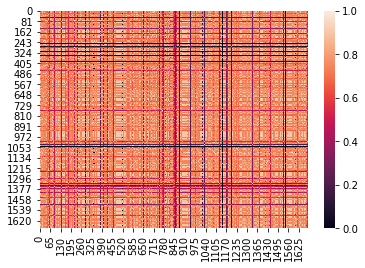

In [1954]:
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C = np.logspace(-2, 1, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma = np.logspace(-2, 0, 4)

# grille de paramètres
param_grid = {'C': C, 'gamma': gamma}

# Choisir un score à optimiser, ici le R2
score = 'r2'

kmatrix = print_SVR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, C, gamma, score)
kmatrix100 = kmatrix[:100, :100]

sns.heatmap(kmatrix)
plt.show()

## VI.2 Régression ridge à noyau

In [75]:
from sklearn.kernel_ridge import KernelRidge

In [76]:
def print_kernelRidge(quant_var, qualit_var, target, df, alphas, gamma, score):
    
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'alpha': alphas, "gamma":gamma}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    KernelRidge(kernel="rbf"), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

In [86]:
# Valeurs possibles du paramètre alpha
alphas = np.logspace(-3, -2, 4)
#alphas = [0.00046]

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma = np.logspace(-3, 0, 4)
#gamma = [1e-2]

# grille de paramètres
param_grid = {'alpha': alphas, 'gamma': gamma}

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_kernelRidge(quant_var, qualit_var, "SiteEnergyUse_log", d2015, alphas, gamma, score)
#kmatrix100 = kmatrix[:100, :100]

#sns.heatmap(kmatrix)
#plt.show()

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.01, 'gamma': 0.01}

Sur le jeu de test : 0.614


# VII Méthodes ensemblistes

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

In [55]:
df2015 = pd.read_csv("./df2015.csv")
df2016 = pd.read_csv("./df2016.csv")
data = pd.read_csv("./data_for_EA.csv")

In [56]:
# On ne garde que les variables pertinentes
cat_df = pd.concat([buildingtypes,
                    #largestptype,
                    yearbuilt,
                    primaryptype
                   ], axis=1) 
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)

features = pd.Index([c for c in d2015.columns if c not in targets])
qualit_var = cat_df.columns
quant_var = pd.Index(c for c in features if c not in qualit_var)

## VII.1 Forêts aléatoires

Premier essai avec l'algorithme RandomForestRegressor sur les mêmes features que précédemment mais sans normalisation, et un nombre d'estimateurs à 100 (valeur par défaut, qui semble donner les meilleurs résultats sur quelques essais.)

In [2007]:
from sklearn.ensemble import RandomForestRegressor

d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)
features = pd.Index([c for c in d2015.columns if c not in targets])

X = d2015[features].to_numpy()
y = d2015["SiteEnergyUse_log"].to_numpy()
                     
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )

rfr = RandomForestRegressor(n_estimators=100, oob_score=True)
model = rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("R2 score: {}".format(r2_score(y_test, y_pred)))

R2 score: 0.7861359840850073


Deuxième essain cette fois avec normalisation des features, et recherche du meilleur nombre d'estimateur;

In [73]:
from sklearn.ensemble import RandomForestRegressor

def print_RFR(quant_var, qualit_var, target, df, n_estimators, score):
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'n_estimators': n_estimators}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    RandomForestRegressor(oob_score=True), # régresseur basé sur l'alogorithme RandomForest
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))
    print("params: ")
    print(regr.get_params())

In [87]:
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)
features = pd.Index([c for c in d2015.columns if c not in targets])

# Valeurs possibles du nombre d'arbres
n_estimators = [100, 200, 500, 1000]

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_RFR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, n_estimators, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_estimators': 500}

Sur le jeu de test : 0.801
params: 
{'cv': 5, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': True, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(oob_score=True), 'iid': 'deprecated', 'n_jobs': None, 'param_grid': {'n_estimators': [100, 200, 500, 1000]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': 'r2', 'verbose': 0}


Pas de différence significative a priori.

## VII.2 GradientBoostingRegressor

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
def print_GBR(quant_var, qualit_var, target, df, n_estimators, score):
    
    try:
        var = np.concatenate((quant_var, qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
    except:
        var = np.concatenate(([quant_var], qualit_var))
        X = df[var].to_numpy().reshape(-1, len(var))
        
    y = df[target].to_numpy()


    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size=0.3 # 30% des données dans le jeu de test
                                    )
    
    quant_var_index = range(0, 5) # 5 variables quantitatives dans le modèle
    qualit_var_index = range(5, len(qualit_var)+len(quant_var))
    
    std_scale = StandardScaler().fit(X_train[:, quant_var_index])
    X_train_quant_std = std_scale.transform(X_train[:, quant_var_index])
    X_test_quant_std = std_scale.transform(X_test[:, quant_var_index])
    
    X_train_std = np.concatenate((X_train_quant_std, X_train[:, qualit_var_index]), axis=1)
    X_test_std = np.concatenate((X_test_quant_std, X_test[:, qualit_var_index]), axis=1)
    
    # Nested cross-validation
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=4)
    
    # Hyperparamètre à optimiser
    param_grid = {'n_estimators': n_estimators}

    # Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
    regr = GridSearchCV(
    GradientBoostingRegressor(), # régresseur basé sur l'alogorithme RandomForest
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

    # Optimiser ce classifieur sur le jeu d'entraînement
    regr.fit(X_train_std, y_train)

    
    # Afficher le(s) hyperparamètre(s) optimaux
    print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
    print(regr.best_params_)

    y_pred = regr.predict(X_test_std)
    print("\nSur le jeu de test : {:.3f}".format(r2_score(y_test, y_pred)))

In [68]:
d2015 = pd.concat([df2015[quantitative_features.append(targets)], cat_df], axis=1)
features = pd.Index([c for c in d2015.columns if c not in targets])

# Valeurs possibles du paramètre alpha
n_estimators = [50, 100, 200, 500]

# Choisir un score à optimiser, ici le R2
score = 'r2'

print_GBR(quant_var, qualit_var, "SiteEnergyUse_log", d2015, n_estimators, score)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_estimators': 200}

Sur le jeu de test : 0.805


# Annexes

In [437]:
# On regroupe TotalGHGEmissions en 10 catégories
deciles = data["TotalGHGEmissions"].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# On groupe TotalGHGEmissions en 10 catégories
bins = deciles[4:-1].to_numpy()
cat_TotalGHG = np.digitize(data.TotalGHGEmissions, bins)

# Création d'une Series pour pouvoir concatener
cat_TotalGHG = pd.Series(data=cat_TotalGHG, name="cat_TotalGHG", index=range(0, cat_TotalGHG.shape[0]))

### Latitude, Longitude

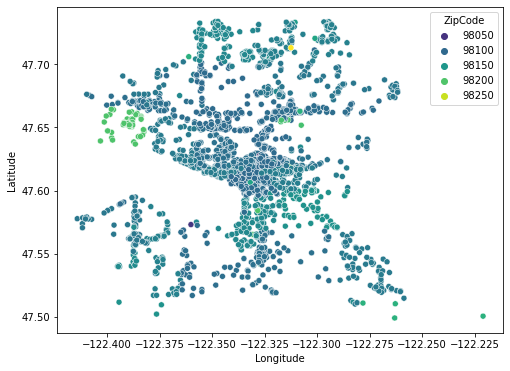

In [945]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Longitude', y="Latitude", data=data[data.ZipCode.notna()], hue="ZipCode", palette="viridis")
plt.show()

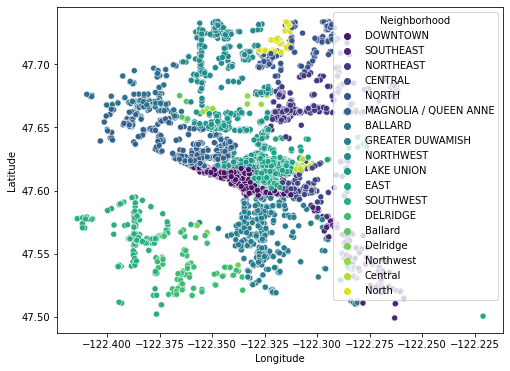

In [446]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Longitude", y='Latitude', data=data, hue="Neighborhood", palette="viridis")
plt.show()